# Homework 4: Modeling Text Data

### Team Member 1:
* UNI:  yh2901
* Name: Emily Hua

### Team Member 2 [optional]:
* UNI:  mz2591
* Name: Ming Zhou


You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

In [766]:
from __future__ import print_function
import sys
if sys.version[0] == '2':
    reload(sys) # python3 has no reload without import and sys.setdefaultencoding, python3 already utf-8
    sys.setdefaultencoding("utf-8")

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import pandas as pd
import requests
import io
if sys.version_info[0] < 3:
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from nltk import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.manifold import MDS
from nltk.tokenize import RegexpTokenizer 
from sklearn.metrics.pairwise import cosine_similarity
import itertools

In [2]:
df = pd.read_csv("Vision_Zero_Entry.csv")

In [3]:
target_raw = df['REQUESTTYPE'].unique()

### Regroup the target

In [4]:
"""
key: grouped topic
value: list of original topics that are grouped under this topic 
"""
topic_group = {
    "bike facilities don't exist or need improvement": ["bike facilities don't exist or need improvement","there are no bike facilities or they need maintenance"],
    'the wait for a walk signal is too long': ['the wait for the "Walk" signal is too long', 'people have to wait too long for the "Walk" signal','" src="images/02 - Wait is too long.png"></span>&nbsp;the wait for the "Walk" signal is too long'],
    "people cross away from the crosswalks":["people cross away from the crosswalks"],
    "people speed":["people speed", '" src="images/06 - Speeding.png"></span>&nbsp;people speed'],
    "people don't yield while turning" : ["people don't yield while turning"],
    "it's too far / too many lanes to cross":["it's too far / too many lanes to cross", "people have to cross too many lanes / too far"],
    "people run red lights / stop signs":['people run red lights / stop signs'],
    "people double park their vehicles":["people double park their vehicles"],
    "people don't yield while going straight":["people don't yield while going straight"],
    "of something that is not listed here":["of something that is not listed here", '" src="images/14 - Other issue.png"></span>&nbsp;of something that is not listed here'],
    "it’s hard to see / low visibility":["it’s hard to see / low visibility", "it’s hard for people to see each other",'" src="images/10 - Hard to see.png"></span>&nbsp;it’s hard to see / low visibility'],
    "the roadway surface needs improvement/maintance":["the roadway surface needs improvement", "the roadway surface needs maintenance",'" src="images/12 - Bike facility issue.png"></span>&nbsp;the roadway surface needs improvement'],
    "sidewalks/ramps don't exist or need improvement":["sidewalks/ramps don't exist or need improvement","there are no sidewalks or they need maintenance",'" src="images/11 - Sidewalk issue.png"></span>&nbsp;sidewalks/ramps don\'t exist or need improvement' ],
    "people are not given enough time to cross the street":["people are not given enough time to cross the street", "there's not enough time to cross the street",'" src="images/01 - Not enough time to cross.png"></span>&nbsp;there\'s not enough time to cross the street']
    }

In [5]:
"""
key: orignal topic
value: grouped topic 
"""
topic_group_reversed = {}
for key in topic_group:
    for item in topic_group[key]:
        topic_group_reversed[item] = key

### Drop duplicates

In [6]:
# remove duplicating comments
print ("orignal raw shape {}".format(df.shape))
df_dedup = df.drop_duplicates(['COMMENTS' , 'REQUESTTYPE'], keep="last")
print ("after removing duplicates, the shape is {}".format(df_dedup.shape))


orignal raw shape (8533, 11)
after removing duplicates, the shape is (6482, 11)


In [7]:
# drop NaN comments 

df_dedup.dropna(subset=['COMMENTS'], inplace=True)

In [8]:
df_dedup['TYPE'] = np.random.randn(df_dedup.shape[0])


In [9]:
df_dedup.columns

Index(['﻿X', 'Y', 'OBJECTID', 'GLOBALID', 'REQUESTID', 'REQUESTTYPE',
       'REQUESTDATE', 'STATUS', 'STREETSEGID', 'COMMENTS', 'USERTYPE', 'TYPE'],
      dtype='object')

In [10]:
df_=df_dedup.copy()

In [11]:
# clean up target
df_['TYPE'] = df_['REQUESTTYPE'].apply(lambda val: topic_group_reversed[val])

In [12]:
topic_int_map = {}
length = len(topic_group)
print ("there are {} grouped topics".format(length))
i = 0
for key in topic_group.keys():
    topic_int_map[key] = i
    i += 1

there are 14 grouped topics


In [13]:
# create interger target 
df__ = df_.copy()
df__['CLASS'] = np.random.randn(df__.shape[0])
df__['CLASS'] = df__['TYPE'].apply(lambda val: topic_int_map[val])

In [14]:
df__[:2]

,﻿X,Y,OBJECTID,GLOBALID,REQUESTID,REQUESTTYPE,REQUESTDATE,STATUS,STREETSEGID,COMMENTS,USERTYPE,TYPE,CLASS
0,-71.071329,42.332161,15607,NaN,15607.0,bike facilities don't exist or need improvement,2016-01-19T22:14:26.000Z,Unassigned,0,the roadway is super wide here with no lane ma...,bikes,bike facilities don't exist or need improvement,7
1,-71.067764,42.374244,15608,NaN,15608.0,"the wait for the ""Walk"" signal is too long",2016-01-19T22:55:29.000Z,Unassigned,0,As someone who walks from SE of the intersecti...,walks,the wait for a walk signal is too long,2


### Visualize the class distribution

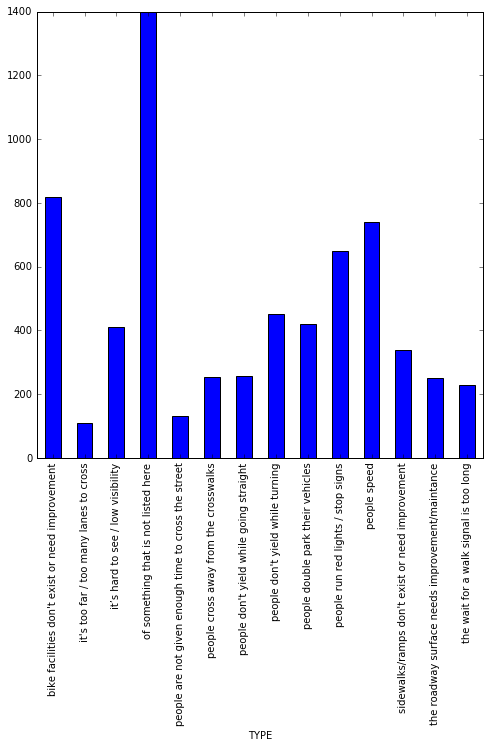

In [15]:
# visualize the class distribution 
%matplotlib inline
df__.groupby('TYPE').count()['COMMENTS'].plot(kind="bar", figsize=(8,8))

In [16]:
text_train, y_train = df__['COMMENTS'], df__['TYPE']

In [17]:
print (text_train.shape, y_train.shape)

(6460,) (6460,)


### Train test split

In [18]:
text_train_sub, text_val, y_train_sub, y_val = train_test_split(text_train, y_train, stratify=y_train, random_state=0)

# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

In [19]:
print (text_train_sub.shape, y_train_sub.shape)

(4845,) (4845,)


In [20]:
text_train_sub[text_train_sub.isnull()]

Series([], Name: COMMENTS, dtype: object)

### Unigram + logistic regression as the baseline model
#### with stemming achieves 0.562 F score

In [21]:
# stemming 
from nltk import word_tokenize
tokenizer = RegexpTokenizer(r'\b\w\w+\b')
class stemTokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer("english")
    def __call__(self, doc):
        return [self.stemmer.stem(w) for w in tokenizer.tokenize(doc)]
vect_stemmed = CountVectorizer(tokenizer=stemTokenizer())

In [22]:
X_train_s = vect_stemmed.fit_transform(text_train_sub)
X_val_s = vect_stemmed.transform(text_val)

In [23]:
# preview some of the stemmed features, check that it indeed performs bag-out-word transformation
feature_names = vect_stemmed.get_feature_names()
print(feature_names[:100])
print(feature_names[1220:1230])
print(feature_names[::400])

['00', '00am', '00pm', '02124', '10', '100', '1000', '1000s', '101', '1010', '109', '10am', '10x', '11', '114', '115', '1161', '11a', '12', '128', '13', '14', '15', '159', '16', '17', '18', '19', '1950s', '1979', '1a', '1asouth', '1st', '20', '200', '2000', '200k', '2014', '2015', '2016', '203', '20mph', '21', '22', '2201', '229', '24', '244', '25', '257', '25mph', '26', '27', '280', '2am', '2hr', '2nd', '30', '300', '30am', '30mph', '30pm', '311', '314', '318', '32', '342', '343', '35', '35mph', '36', '365', '37', '39', '390', '3a', '3am', '3rd', '40', '40mph', '426', '45', '45am', '473', '4pm', '4th', '50', '500', '501', '503', '50mph', '50s', '51', '524', '544', '55', '555', '564', '57', '5am']
['drawbridg', 'dreden', 'dresden', 'dresser', 'drew', 'drift', 'drive', 'driven', 'driver', 'driveway']
['00', 'balanc', 'circul', 'doublepark', 'frogger', 'ink', 'metal', 'perfect', 'roxs', 'stream', 'upcom']


In [24]:
vect = CountVectorizer()
X_train = vect.fit_transform(text_train_sub)
X_val = vect.transform(text_val)

In [25]:
X_train, X_val

(<4845x5782 sparse matrix of type '<class 'numpy.int64'>'
 	with 104414 stored elements in Compressed Sparse Row format>,
 <1615x5782 sparse matrix of type '<class 'numpy.int64'>'
 	with 33797 stored elements in Compressed Sparse Row format>)

In [26]:

# preview some of the regular features, check that it indeed performs bag-out-word transformation

feature_names = vect.get_feature_names()
print(feature_names[:10])
print(feature_names[1220:1230])
print(feature_names[::400])

['00', '00am', '00pm', '02124', '10', '100', '1000', '1000s', '101', '1010']
['converted', 'coordinate', 'coordinated', 'cop', 'copley', 'coppersmith', 'cops', 'corey', 'corinth', 'corner']
['00', 'arundel', 'bunch', 'continuously', 'downhill', 'fiedler', 'hell', 'juliette', 'meters', 'overlaps', 'pulls', 'sb', 'standards', 'tour', 'weekend']


In [27]:
# run a baseline multi-class classification with logistic regression 
lr = LogisticRegressionCV(scoring="f1").fit(X_train, y_train_sub)


In [28]:
#Array of C (regularization, smaller the C larger the regularization) that maps to the best scores across every class.
lr.C_

array([  2.78255940e+00,   1.00000000e+04,   2.15443469e+01,
         2.15443469e+01,   2.78255940e+00,   2.78255940e+00,
         2.78255940e+00,   2.78255940e+00,   2.15443469e+01,
         2.78255940e+00,   2.78255940e+00,   2.15443469e+01,
         2.15443469e+01,   2.78255940e+00])

In [29]:
lr.score(X_val, y_val) # get 0.52 accuracy which is indeed above 0.5) 

0.54984520123839009

In [30]:
# run a baseline multi-class classification with logistic regression 
lr_s = LogisticRegressionCV(scoring="f1_macro").fit(X_train_s, y_train_sub)


In [31]:
lr_s.C_

array([   0.35938137,  166.81005372,    2.7825594 ,    2.7825594 ,
          2.7825594 ,    2.7825594 ,    2.7825594 ,   21.5443469 ,
         21.5443469 ,    0.35938137,    0.35938137,   21.5443469 ,
          2.7825594 ,   21.5443469 ])

In [32]:
lr_s.score(X_val_s, y_val) # get 0.55 accuracy, suggests stemming helps! we are going to use the stemmed version of the dataset

0.55727554179566563

In [33]:
assert lr_s.score(X_val_s, y_val) > 0.5

### Visualize the confusion matrix

In [34]:
# visualize the confusion matrix
print(classification_report(y_val, lr_s.predict(X_val_s)))

                                                      precision    recall  f1-score   support

     bike facilities don't exist or need improvement       0.68      0.73      0.70       204
              it's too far / too many lanes to cross       0.20      0.26      0.23        27
                   it’s hard to see / low visibility       0.66      0.56      0.61       103
                of something that is not listed here       0.45      0.48      0.47       350
people are not given enough time to cross the street       0.57      0.12      0.20        33
               people cross away from the crosswalks       0.40      0.42      0.41        64
             people don't yield while going straight       0.43      0.25      0.32        64
                    people don't yield while turning       0.40      0.38      0.39       113
                   people double park their vehicles       0.75      0.74      0.75       105
                  people run red lights / stop signs       

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int((cm[i, j] * 100) + 0.5) / 100.0,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix


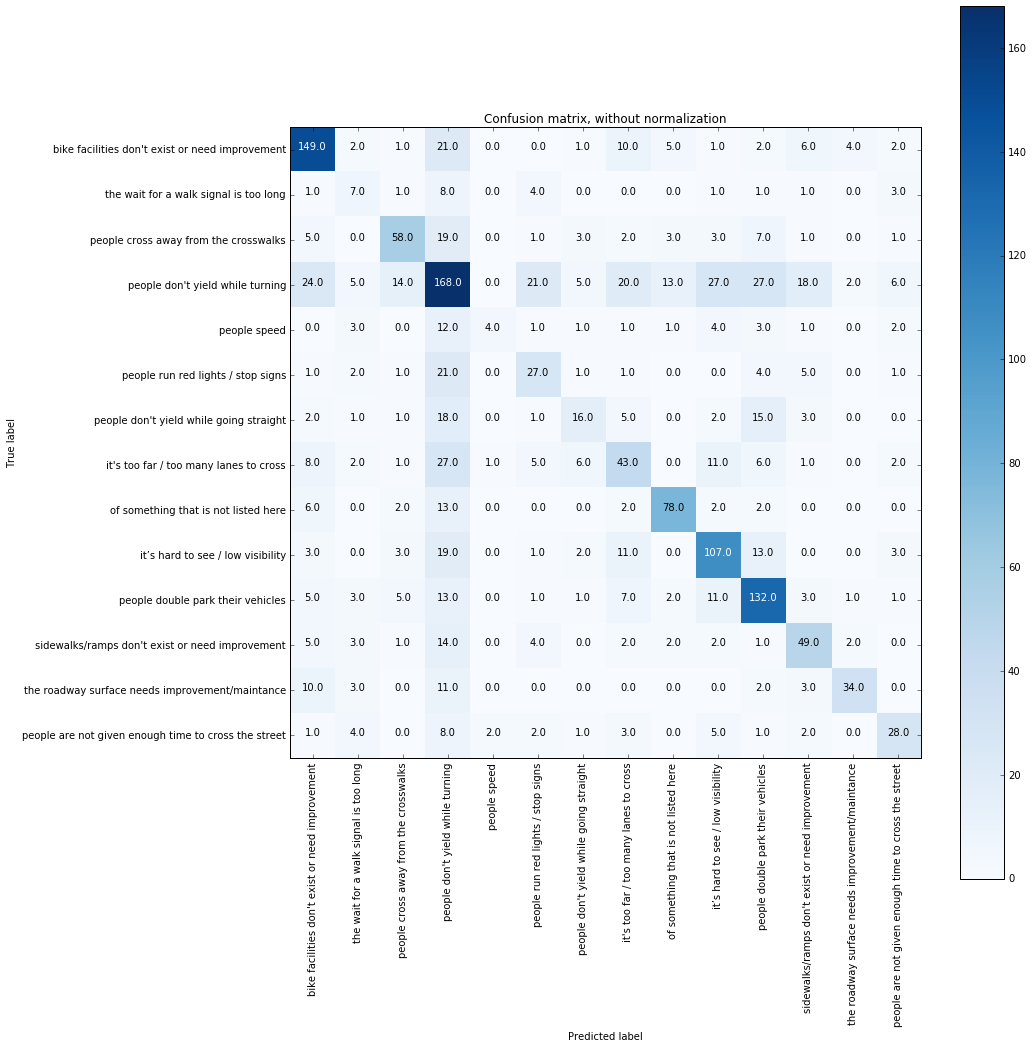

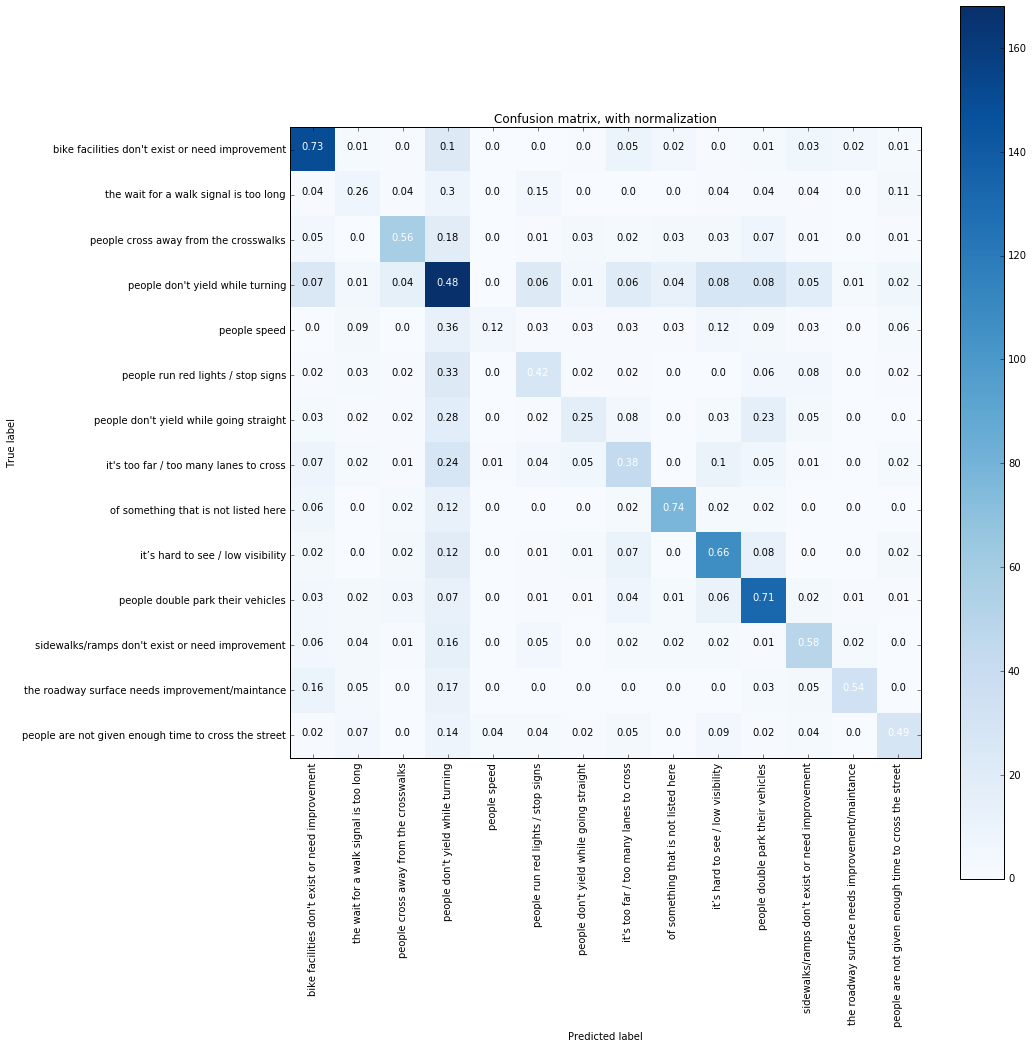

In [36]:
# Compute confusion matrix
class_names = df__['TYPE'].unique()
cnf_matrix = confusion_matrix(y_val, lr_s.predict(X_val_s))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')

plt.show()

In [37]:
# what mistakes does the model make?

The diagonal value shows number of poinsts labeled correct, the higher the value, the better the performance. And we observed the "bike faciities don't exist or need improvement" has the highest correctness (0.74). But classes like "people speed" and "the wait for a walk signal is too long" has very low correctness, only around 0.18 fraction of the classes are correctly labeled. For the case of "the wait for a walk signal is too long",  0.22 fraction of them are mispredicted as "people don't yeild while turning" and 0.19 fraction of it are mislabeled as "people run red lights/stop signs". The reason could be that multiple classes contain similar words and the document similarity are very high.

# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

#### best score goes to trigram tfidf: 0.57x

In [38]:
print (text_train_sub.shape, y_train_sub.shape)

(4845,) (4845,)


### n-grams (1,3)
achieves 0.559



In [39]:
# improve the model by n-grams
vect3 = CountVectorizer(tokenizer=stemTokenizer(), ngram_range=(1, 3), min_df=4)

In [40]:
X_train3 = vect3.fit_transform(text_train_sub)
X_val3 = vect3.transform(text_val)

In [41]:
vect3.get_feature_names()[201:210]

['also the',
 'altern',
 'although',
 'although there',
 'alway',
 'alway cross',
 'alway doubl',
 'alway doubl park',
 'alway full']

In [42]:
lr3 = LogisticRegressionCV(scoring='f1_macro').fit(X_train3, y_train_sub)

In [43]:
lr3.C_

array([  2.78e+00,   1.00e+04,   1.29e+03,   1.29e+03,   2.15e+01,
         2.15e+01,   1.00e+04,   2.15e+01,   1.67e+02,   3.59e-01,
         2.78e+00,   2.15e+01,   2.78e+00,   1.67e+02])

In [44]:
lr3.score(X_val3, y_val)

0.55913312693498451

### TF-IDF
#### achieves 0.572

In [45]:
tfidf = TfidfVectorizer(tokenizer=stemTokenizer(), ngram_range=(1, 3), min_df=3, stop_words='english')
X_train_tfidf = tfidf.fit_transform(text_train_sub)
lr_tfidf = LogisticRegressionCV(scoring="f1_macro").fit(X_train_tfidf, y_train_sub)
X_val_tfidf = tfidf.transform(text_val)
lr_tfidf.score(X_val_tfidf, y_val)

0.57213622291021671

### Character n-gram

In [46]:
char_vect = CountVectorizer(tokenizer=stemTokenizer(), ngram_range=(1, 3), min_df=4, analyzer="char_wb")
X_train_char = char_vect.fit_transform(text_train_sub)

In [47]:
len(char_vect.vocabulary_)

4474

In [48]:
lr_char = LogisticRegressionCV(scoring="f1_macro").fit(X_train_char, y_train_sub)
X_val_char = char_vect.transform(text_val)
lr_char.score(X_val_char, y_val)

0.53808049535603719

#### best model: uni+bigram+trigram tfidf has the highest f1 score as 0.572

# Task4 - Visualize Results [10 points]

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

### Feature importance

In [49]:
# important features

def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")


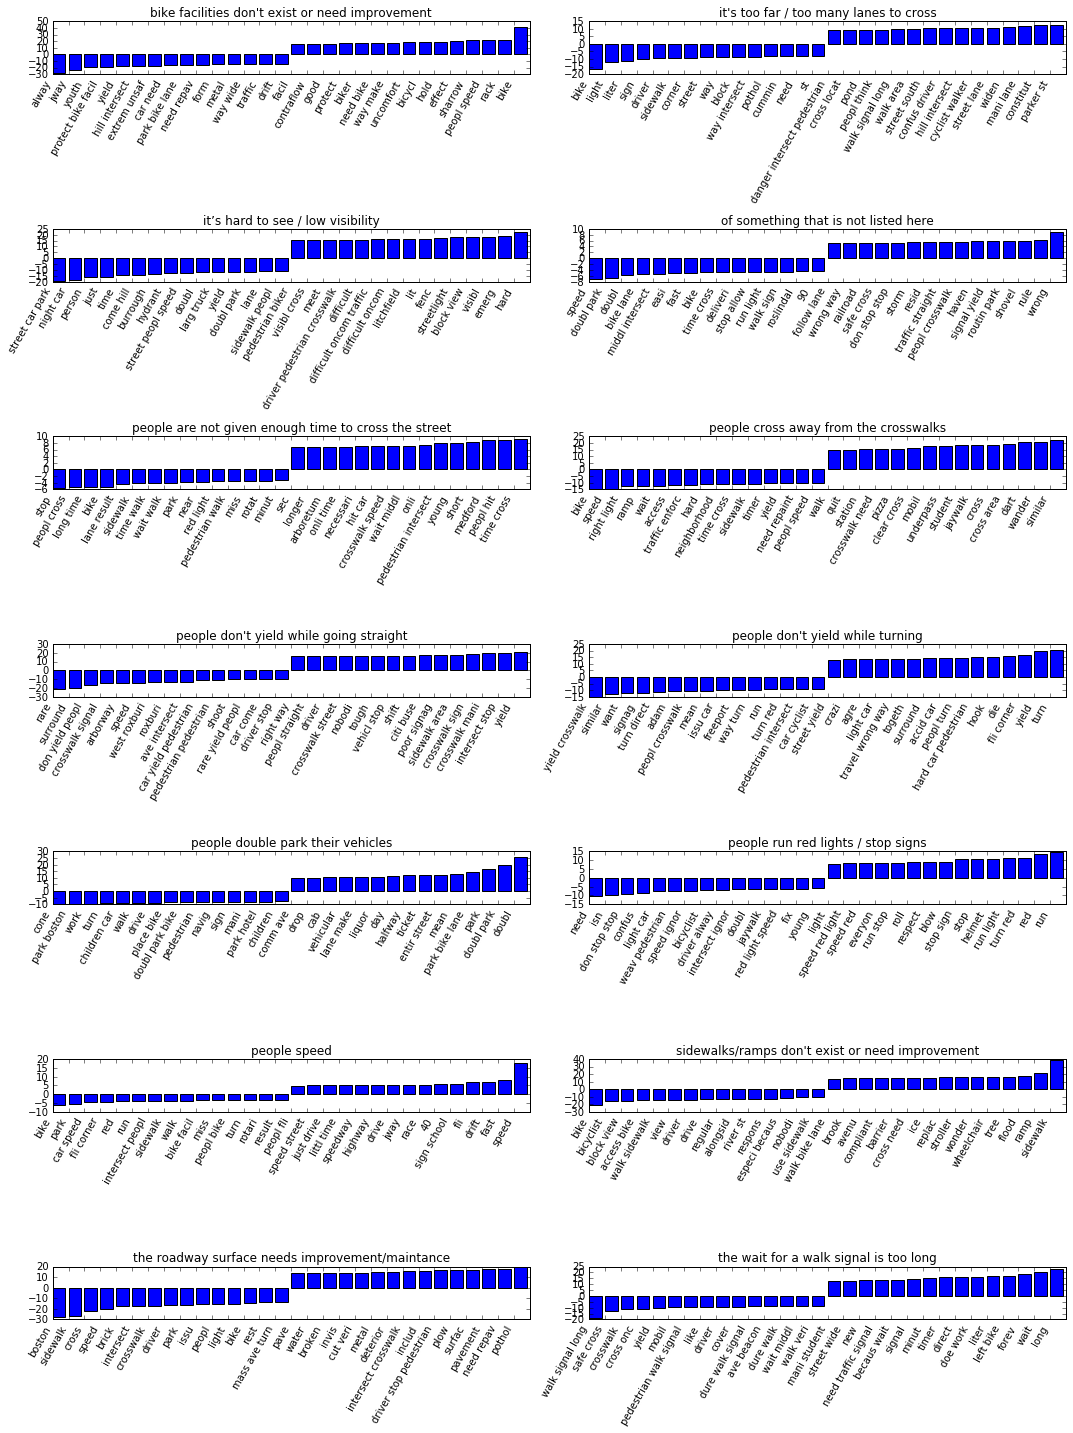

In [50]:
# plot uni+bi+tri-gram model 

n_classes = len(lr_tfidf.classes_)
feature_names = np.array(tfidf.get_feature_names())
fig, axes = plt.subplots(n_classes // 3+3, 2, figsize=(15, 20))
for ax, coef, label in zip(axes.ravel(), lr_tfidf.coef_, lr_tfidf.classes_):
    ax.set_title(label)
    plot_important_features(coef, feature_names, top_n=15, ax=ax)
    
plt.tight_layout()

In [51]:
# single plot uni+bi+tri-gram model 
# plt.figure(figsize=(15, 4))
# plot_important_features(lr3.coef_[0], np.array(vect3.get_feature_names()), top_n=20)

### Classification result and Confusion matrix

In [52]:
print(classification_report(y_val, lr_tfidf.predict(X_val_tfidf)))

                                                      precision    recall  f1-score   support

     bike facilities don't exist or need improvement       0.70      0.74      0.72       204
              it's too far / too many lanes to cross       0.25      0.11      0.15        27
                   it’s hard to see / low visibility       0.60      0.54      0.57       103
                of something that is not listed here       0.44      0.55      0.49       350
people are not given enough time to cross the street       0.40      0.18      0.25        33
               people cross away from the crosswalks       0.60      0.45      0.52        64
             people don't yield while going straight       0.42      0.22      0.29        64
                    people don't yield while turning       0.46      0.41      0.43       113
                   people double park their vehicles       0.84      0.77      0.80       105
                  people run red lights / stop signs       

Confusion matrix, without normalization
Normalized confusion matrix


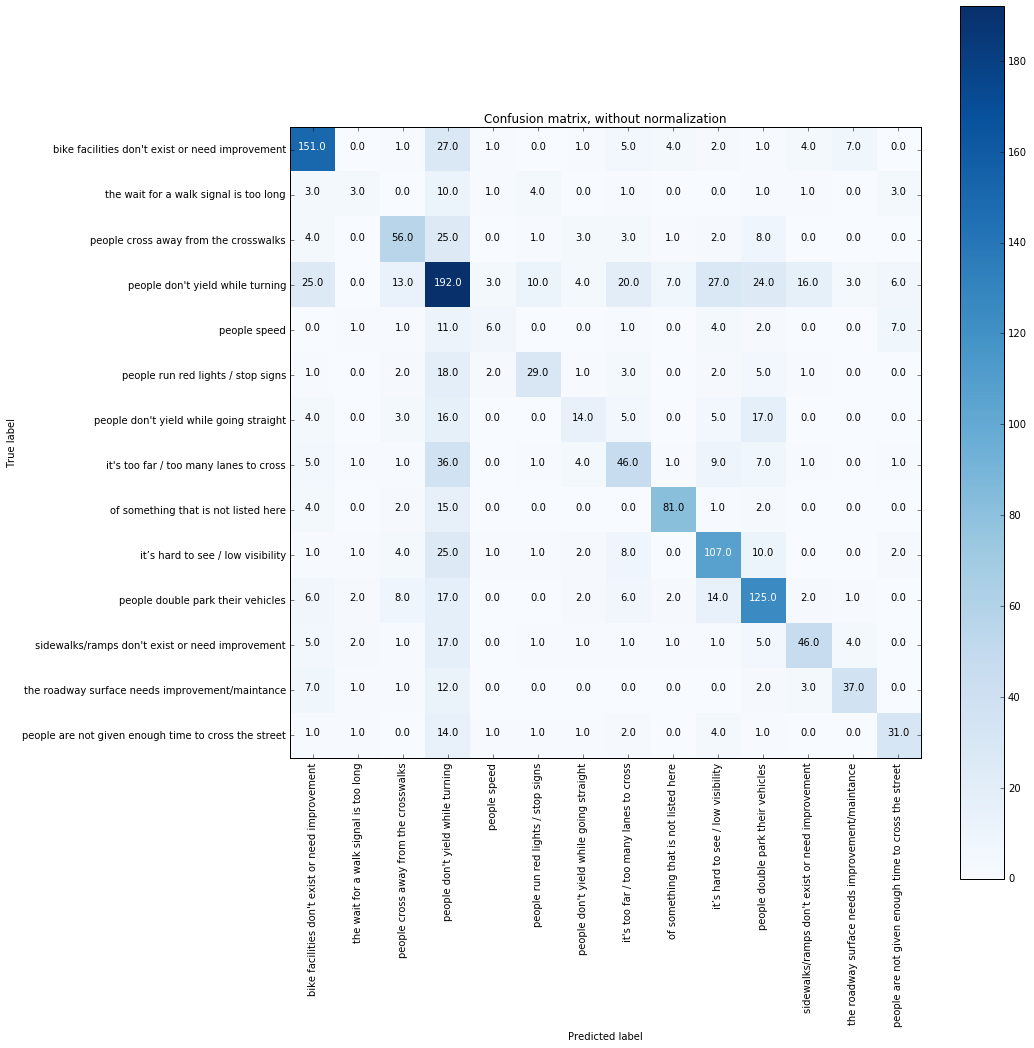

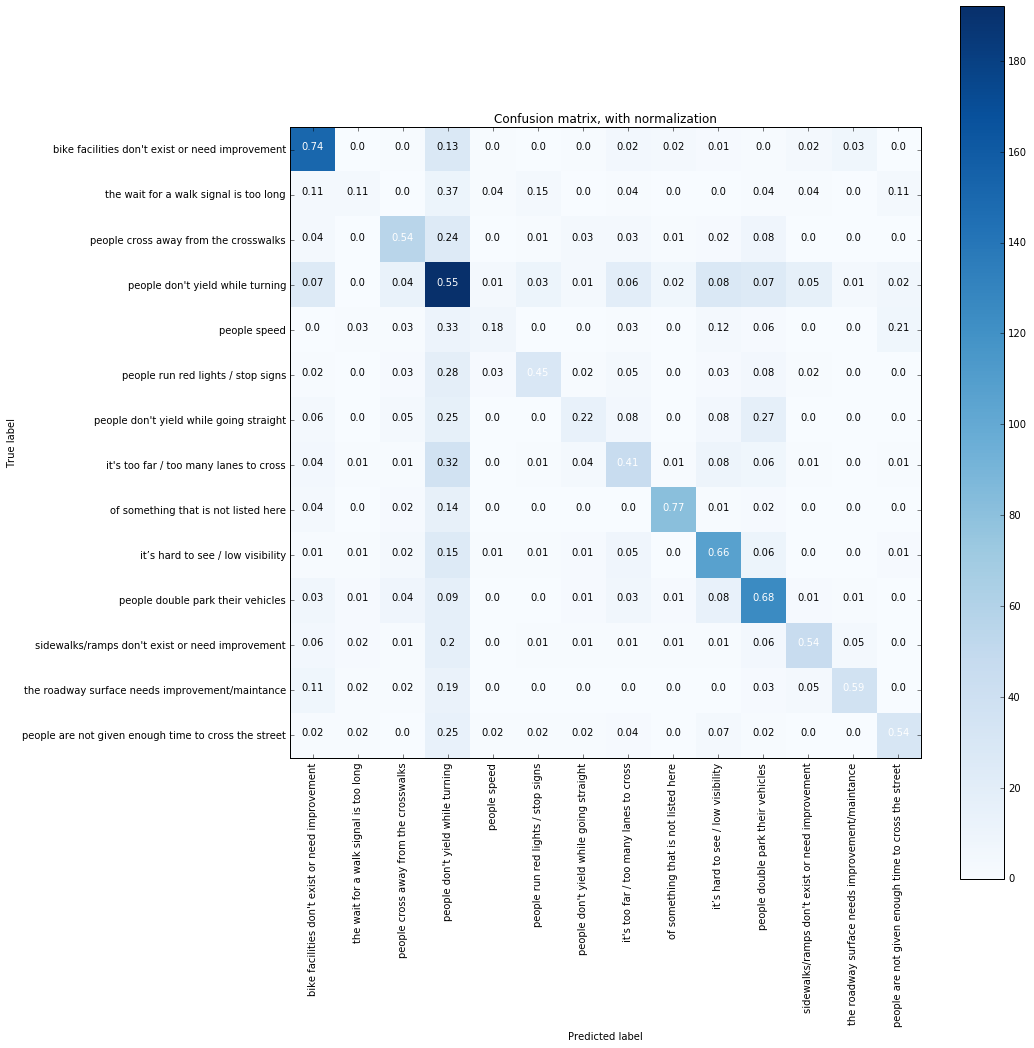

In [53]:
# Compute confusion matrix
class_names = df__['TYPE'].unique()
cnf_matrix = confusion_matrix(y_val, lr_tfidf.predict(X_val_tfidf))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization')

plt.show()

### Mistakes 
the model tend to misclassify data entries as **people don't yield while turning**. Given the confusion matrix plot, we can see that for each class, on average close to 20% percent of the data entries are mislabeled as **people don't yield while turning**

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

#### NMF has the highest ARI score as 0.11, while K-means and LDA only has 0.08 and 0.03 for stemmed text 

In [54]:
# text_train_sub, text_val, y_train_sub, y_val = train_test_split(text_train, y_train, stratify=y_train, random_state=0)

In [55]:
# tfidf = TfidfVectorizer (ngram_range=(1, 3), min_df=3, stop_words='english')
# X_train_tfidf = tfidf.fit_transform(text_train_sub)
# lr_tfidf = LogisticRegressionCV(scoring="f1_macro").fit(X_train_tfidf, y_train_sub)
# X_val_tfidf = tfidf.transform(text_val)
# lr_tfidf.score(X_val_tfidf, y_val)

### NMF

In [56]:
# scale the data
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_train_tfidf)
X_test_scaled = scaler.transform(X_val_tfidf)

In [57]:
nmf_scale = NMF(n_components=14, verbose=14, tol=0.01)
nmf_scale.fit(X_scaled)

violation: 1.0
violation: 0.4428804111519511
violation: 0.3082796126748418
violation: 0.22940868796648223
violation: 0.1715529258229024
violation: 0.13245625138691855
violation: 0.11901500482456617
violation: 0.11473811830888028
violation: 0.10906121581546403
violation: 0.0940410797282256
violation: 0.07433076442487475
violation: 0.055562785390090345
violation: 0.04116593840004566
violation: 0.030272081900229043
violation: 0.022501004433444684
violation: 0.016322174464225115
violation: 0.012390087778003359
violation: 0.009590416134190023
Converged at iteration 18


NMF(alpha=0.0, beta=1, eta=0.1, init=None, l1_ratio=0.0, max_iter=200,
  n_components=14, nls_max_iter=2000, random_state=None, shuffle=False,
  solver='cd', sparseness=None, tol=0.01, verbose=14)

In [58]:
X_nmf_scale = nmf_scale.transform(X_scaled)

violation: 1.0
violation: 0.20092635374570633
violation: 0.007526839028814028
Converged at iteration 3


In [59]:
X_nmf_scale

array([[ 0.07,  0.  ,  0.  , ...,  0.  ,  0.19,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.08,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.01,  0.01,  0.  , ...,  0.03,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.11, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.1 ,  0.  ,  0.  ]])

### ARI of NMF

#### around 0.12

In [60]:
# ARI score for NMF
adjusted_rand_score(y_train_sub, X_nmf_scale.argmax(axis=1))

0.12417538401883323

In [61]:
coef = [1,2]
np.argsort(coef)[-1:]

array([1])

#### NMF topics

In [62]:

def plot_important_features_clustering(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:][::-1] # find top_n coef's index with largest absolute value 
    important_coefs = coef[inds] # get actual coef value 
    myrange = range(len(inds))
    print (inds)
#     sort_sign = np.argsort(important_coefs) # no need, as NMF and LDA does not produce negative value, but LSA will 
#     combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[inds], rotation=60, ha="right")
    print (feature_names[inds])

topic 1's top 20 features: 
[ 442 2671  463 3425 4437 4157 4159 3674 1472 4161  259 4374 3774 3229 3673
 4910 3434 2055 5590 3249]
['bike' 'lane' 'bike lane' 'need' 'road' 'protect' 'protect bike'
 'park bike lane' 'cyclist' 'protect bike lane' 'ave' 'right' 'path' 'mark'
 'park bike' 'space' 'need bike' 'facil' 'travel' 'mass']
topic 2's top 20 features: 
[5655 2826 4374 5694 2865 5174 2671 4416 5716 3138 5731 3603 2843 5690 3158
 3160 3609 2739 2869 1795]
['turn' 'left' 'right' 'turn left' 'left turn' 'straight' 'lane'
 'right turn' 'turn onli' 'make' 'turn right' 'onli' 'left lane'
 'turn lane' 'make left' 'make left turn' 'onli lane' 'lane left'
 'left turn onli' 'driver']
topic 6's top 20 features: 
[3799 1795 1669 6254 3818 1710 6267 6269 1713 1810 1356 1812 5122  791 1697
 1867 1472 3916 4374 1868]
['pedestrian' 'driver' 'don' 'yield' 'pedestrian crosswalk' 'don yield'
 'yield pedestrian' 'yield pedestrian crosswalk' 'don yield pedestrian'
 'driver don' 'crosswalk' 'driver don y

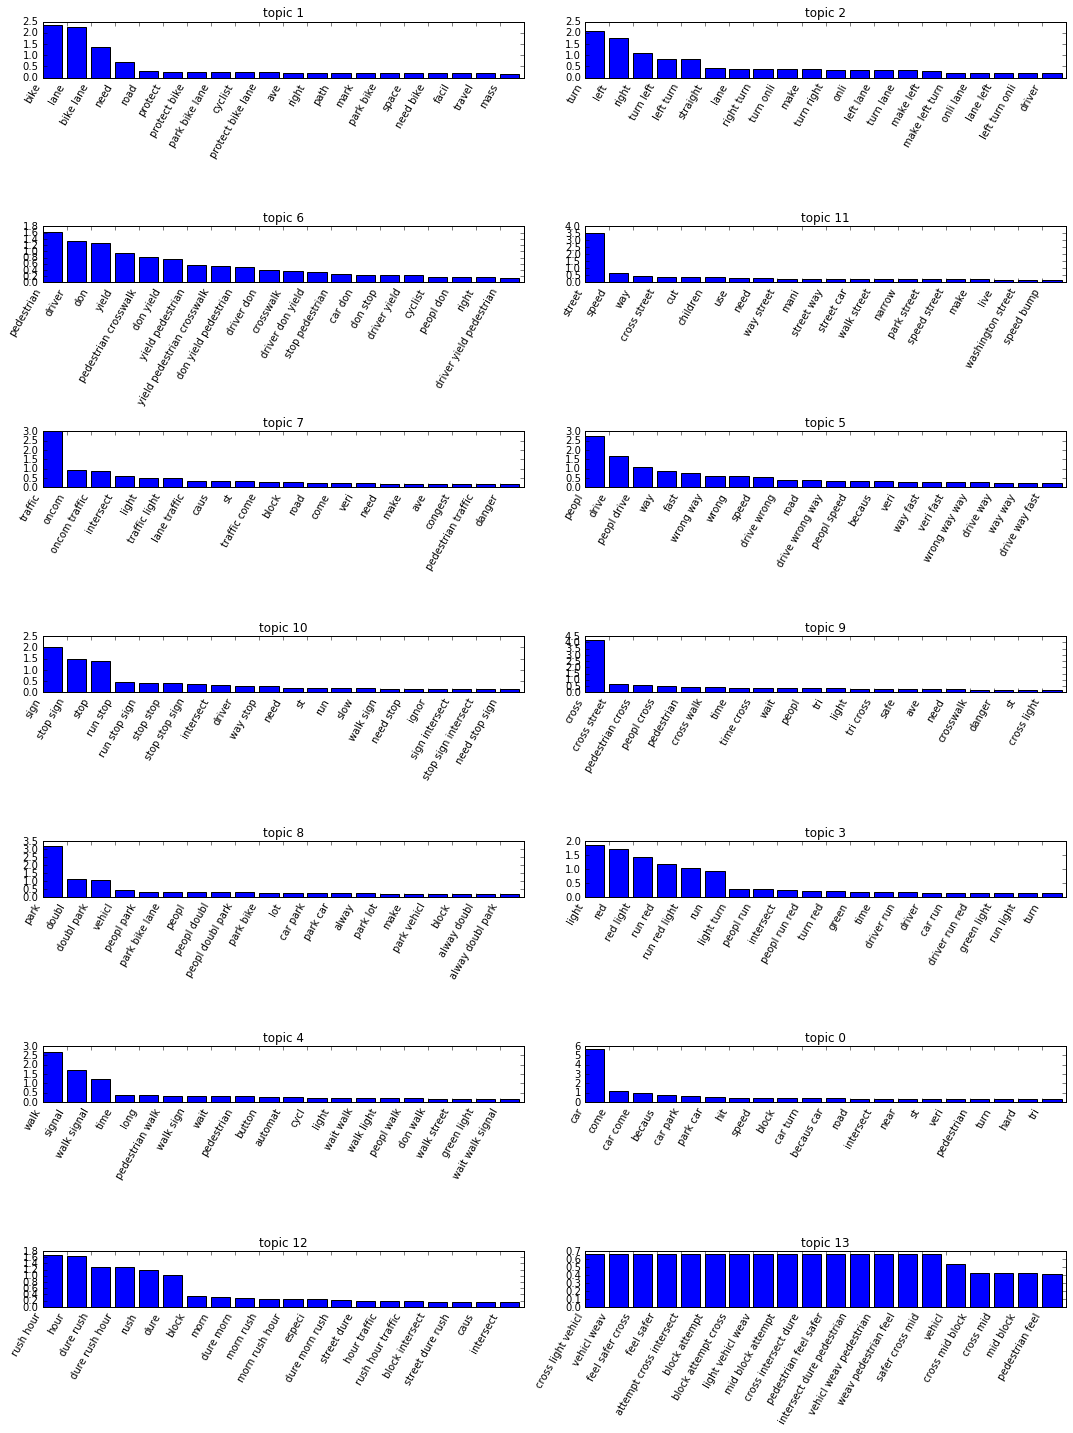

In [63]:
large_comp_inds = np.argsort(X_nmf_scale.mean(axis=0))[::-1]

feature_names = np.array(tfidf.get_feature_names())
n_components = 14
fig, axes = plt.subplots(n_components // 3 + 3, 2, figsize=(15, 20))
ith = 0
for ax, coef in zip(axes.ravel(), nmf_scale.components_[large_comp_inds, :]):
    print ("topic {}'s top 20 features: ".format(large_comp_inds[ith]))
    ax.set_title("topic " + str(large_comp_inds[ith]))
    ith += 1
    plot_important_features_clustering(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()

In [64]:
large_comp_inds = np.argsort(X_nmf_scale.mean(axis=0))[::-1]
large_comp_inds 

array([ 1,  2,  6, 11,  7,  5, 10,  9,  8,  3,  4,  0, 12, 13])

In [65]:
X_nmf_scale.mean(axis=0)

array([ 0.01,  0.03,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,
        0.02,  0.02,  0.02,  0.01,  0.  ])

In [66]:
# topics by most frequent words
def print_topics(topics, feature_names, components, topics_per_chunk=4,
                 n_words=20):
    sorting = np.argsort(components, axis=1)[:, ::-1]
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<18}" * len_this_chunk).format(*these_topics)) # these_topics a list of topic number on this line
        print(("-------- {0:<15}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<23} " * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [67]:
sorting = np.argsort(nmf_scale.components_, axis=1)[:, ::-1]
sorting[[2,1,11,7], 0]

array([5655,  442, 5189, 5480])

In [68]:
large_comp_inds = np.argsort(X_nmf_scale.mean(axis=0))[::-1]
feature_names = np.array(tfidf.get_feature_names())
print_topics(large_comp_inds, feature_names, nmf_scale.components_)

topic 1                 topic 2                 topic 6                 topic 11                
--------                --------                --------                --------                
bike                    turn                    pedestrian              street                  
lane                    left                    driver                  speed                   
bike lane               right                   don                     way                     
need                    turn left               yield                   cross street            
road                    left turn               pedestrian crosswalk    cut                     
protect                 straight                don yield               children                
protect bike            lane                    yield pedestrian        use                     
park bike lane          right turn              yield pedestrian crosswalk need                    
cyclist                 tur

#### Well matched for NMF
Component4: matches   **bike facilities don't exist or need improvement**, we have top 20 features containing: ['bike' 'lane' 'bike lane' 'need' 'road' 'protect' 'protect bike'
 'park bike lane' 'cyclist' 'protect bike lane' 'right' 'ave' 'path' 'mark'
 'need bike' 'park bike' 'space' 'car' 'travel' 'facil']   
 
Component11: matches **people speed**, we have top 20 features for Component2 containing:['peopl' 'drive' 'peopl drive' 'speed' 'fast' 'peopl speed' 'way' 'becaus'
 'veri' 'road' 'peopl cross' 'veri fast' 'cut' 'don' 'way fast'
 'peopl bike' 'fli' 'peopl don' 'yield peopl' 'drive way']   
 
Component8: matches **the wait for a walk signal is too long**, we have top 20 features including ['walk' 'signal' 'walk signal' 'time' 'long' 'pedestrian walk' 'walk sign'
 'wait' 'button' 'pedestrian' 'automat' 'cycl' 'light' 'wait walk'
 'walk light' 'peopl walk' 'don walk' 'walk street' 'green light'
 'wait walk signal']
 
Component10: matches **people run red lights / stop signs**, we have top 20 features including: ['sign' 'stop sign' 'stop' 'run stop' 'run stop sign' 'stop stop'
 'stop stop sign' 'intersect' 'way stop' 'need' 'st' 'run' 'car'
 'walk sign' 'slow' 'need stop' 'sign intersect' 'ignor'
 'stop sign intersect' 'need stop sign']   

Component1: matches **people double park their vehicles**, we observe top 20 features:['park' 'doubl' 'car' 'doubl park' 'car park' 'park car' 'vehicl'
 'peopl park' 'block' 'park bike lane' 'peopl doubl' 'alway'
 'peopl doubl park' 'park bike' 'lot' 'make' 'close' 'car doubl park'
 'car doubl' 'park lot'] 

Component6: matches **people don't yield while turning**, we have top 20 features including ['pedestrian' 'don' 'car' 'yield' 'pedestrian crosswalk' 'don yield'
 'yield pedestrian' 'yield pedestrian crosswalk' 'don yield pedestrian'
 'car don' 'crosswalk' 'driver don' 'stop pedestrian' 'don stop'
 'driver don yield' 'peopl don' 'car don yield' 'cyclist'
 'pedestrian cross' 'car don stop']
  


### LDA

#### ARI as 0.022

In [69]:
lda = LatentDirichletAllocation(n_topics=14, learning_method="batch")
X_lda = lda.fit_transform(X_train_tfidf)

In [70]:
large_comp_inds = np.argsort(X_lda.sum(axis=0))[::-1]
large_comp_inds

array([ 5,  1,  0,  9, 13, 10,  8,  3,  2, 12,  6, 11,  4,  7])

In [71]:
# LDA ARI score
adjusted_rand_score(y_train_sub, X_lda.argmax(axis=1))

0.024046736834136617

Component 5 has top 20 features as: 
[3885 4924 3799 5099 1241 5189  753 1356 5993 4720 3668 2899 1193 5426 1795
 5134 2386 3138 5869 4687]
['peopl' 'speed' 'pedestrian' 'stop' 'cross' 'street' 'car' 'crosswalk'
 'walk' 'sign' 'park' 'light' 'corner' 'time' 'driver' 'stop sign' 'hit'
 'make' 'veri' 'sidewalk']
Component 1 has top 20 features as: 
[ 442 2671 3668  463 1728 1729  753  571 5480 3885  143 4437 5189 3673  456
 2055 3921  693 3774 3674]
['bike' 'lane' 'park' 'bike lane' 'doubl' 'doubl park' 'car' 'block'
 'traffic' 'peopl' 'alway' 'road' 'street' 'park bike' 'bike facil' 'facil'
 'peopl doubl' 'bus' 'path' 'park bike lane']
Component 0 has top 20 features as: 
[4254 4535 2899 4262 4542 4543  753 2537 3885 5002 1241 5189 1795 3799 4924
 5993 2375 5655 5723 4720]
['red' 'run' 'light' 'red light' 'run red' 'run red light' 'car'
 'intersect' 'peopl' 'st' 'cross' 'street' 'driver' 'pedestrian' 'speed'
 'walk' 'hill' 'turn' 'turn red' 'sign']
Component 9 has top 20 features as: 
[

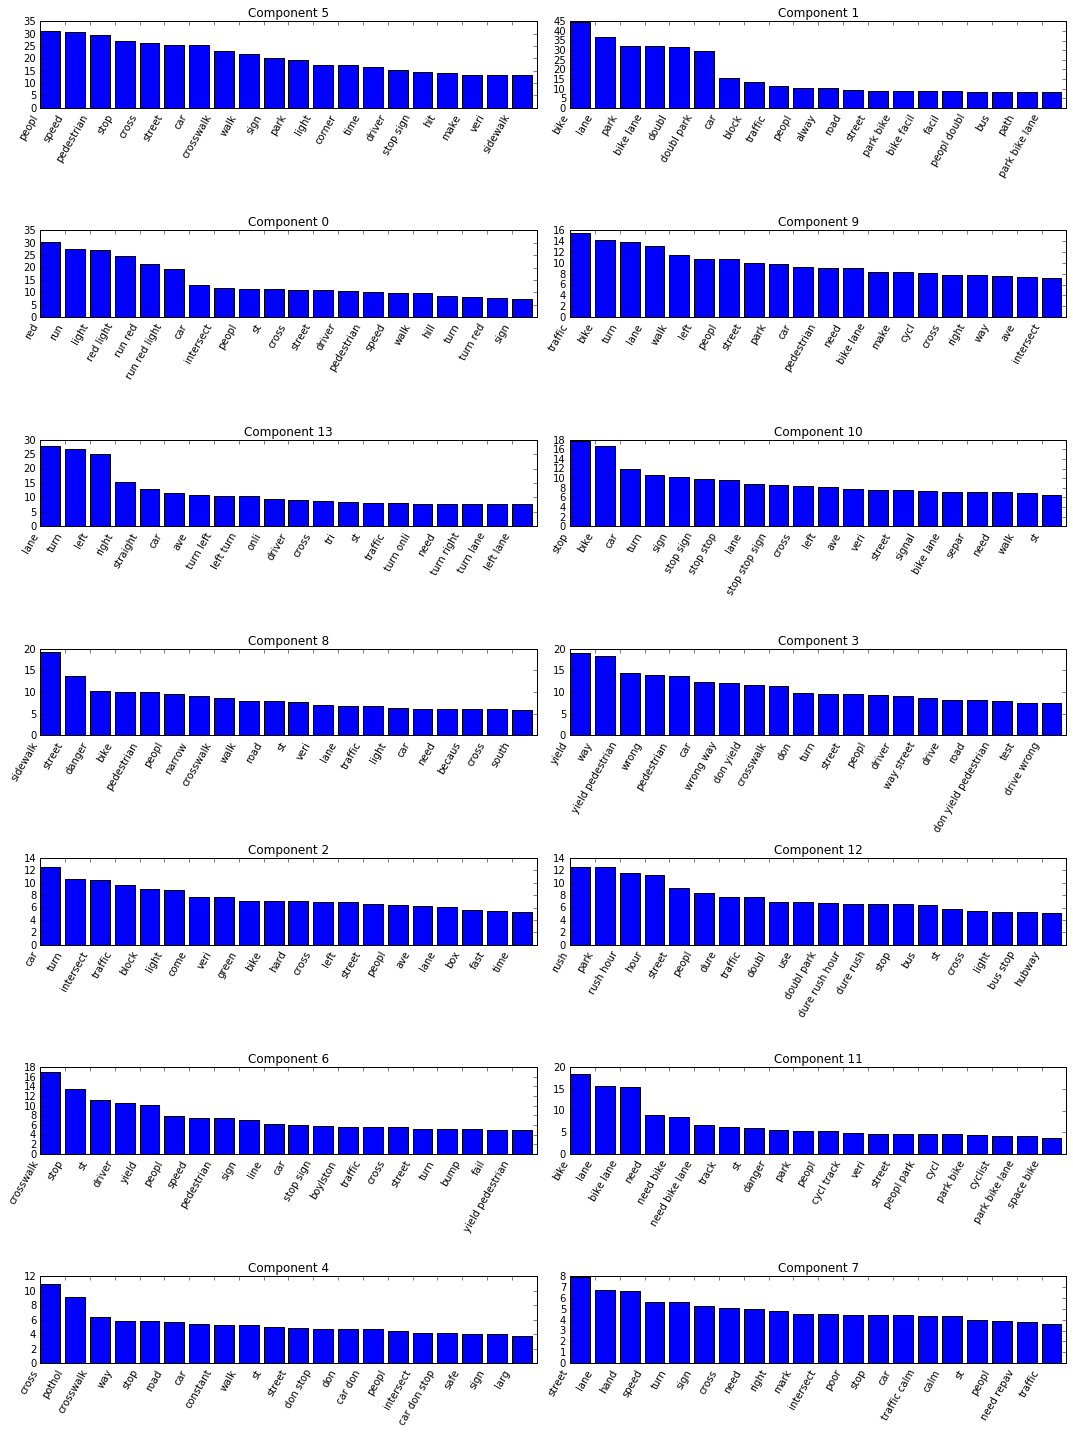

In [72]:
feature_names = np.array(tfidf.get_feature_names())
large_comp_inds = np.argsort(X_lda.sum(axis=0))[::-1][:30]
n_components = 14
fig, axes = plt.subplots(n_components // 3 + 3, 2, figsize=(15, 20))
i = 0
for ax, coef in zip(axes.ravel(), lda.components_[large_comp_inds, :]):
    print ("Component {} has top 20 features as: ".format(large_comp_inds[i]))
    ax.set_title("Component " + str(large_comp_inds[i]))
    i+=1
    plot_important_features_clustering(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()

In [73]:
np.argsort(X_lda.sum(axis=0))[::-1]

array([ 5,  1,  0,  9, 13, 10,  8,  3,  2, 12,  6, 11,  4,  7])

In [74]:
print_topics(np.argsort(X_lda.sum(axis=0))[::-1], feature_names, lda.components_, topics_per_chunk=4)

topic 5                 topic 1                 topic 0                 topic 9                 
--------                --------                --------                --------                
peopl                   bike                    red                     traffic                 
speed                   lane                    run                     bike                    
pedestrian              park                    light                   turn                    
stop                    bike lane               red light               lane                    
cross                   doubl                   run red                 walk                    
street                  doubl park              run red light           left                    
car                     car                     car                     peopl                   
crosswalk               block                   intersect               street                  
walk                    traffi

#### Well matched ones for LDA: 

Component 5 and 11 matches **people don't yield while turning**, it has top 20 features as: 
['signal' 'need' 'bike' 'walk' 'walk signal' 'crosswalk' 'st' 'yield'
 'cross' 'don' 'don yield' 'peopl' 'lane' 'pedestrian' 'cycl' 'bike lane'
 'don yield pedestrian' 'track' 'light' 'wait']
 
 Component 4 matches **people double park their vehicles** it has top 20 features as: 
['park' 'doubl park' 'doubl' 'bike' 'park bike' 'lane' 'park bike lane'
 'bike lane' 'peopl doubl' 'peopl doubl park' 'car' 'street' 'facil'
 'bike facil' 'car doubl' 'car doubl park' 'peopl' 'taxi' 'doubl park bike'
 'car park']
 

#### Could be matching:  
 Component 9 matches **the wait for a walk signal is too long**, it has top 20 features as: 
['st' 'veri fast' 'crosswalk' 'drive veri' 'veri' 'park' 'pedestrian'
 'cross' 'drive veri fast' 'wait' 'peopl' 'traffic' 'station' 'bike'
 'signal' 'fast' 'walk' 'car' 'long' 'stop']
 
Component 8 (could be) matching **people run red lights / stop signs**, with foucs on **stop sign**, it has top 20 features as: 
['stop' 'car' 'sign' 'light' 'way' 'peopl' 'walk' 'cross' 'street'
 'pedestrian' 'turn' 'stop sign' 'driver' 'come' 'speed' 'time' 'st'
 'drive' 'intersect' 'traffic']  


### K-means
#### ARI as 0.11

In [75]:
km = KMeans(n_clusters=14, random_state=0)
km.fit(X_train_tfidf)
print(km.cluster_centers_.shape)
print(km.labels_.shape)
# predict is the same as labels_ on training data
# but can be applied to new data
print(km.predict(X_train_tfidf).shape)


(14, 6298)
(4845,)
(4845,)


In [76]:
km_predicted = km.predict(X_val_tfidf)

In [77]:
# K-means ARI
adjusted_rand_score(y_val, km_predicted)

0.11985048661331706

In [78]:
adjusted_rand_score(y_train_sub, km.labels_)

0.11391109408899255

In [79]:
set(km_predicted)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

In [80]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1] # [::-1] put the most important features to the left most 

In [81]:
km.cluster_centers_.argsort()

array([[   0, 3970, 3969, ..., 3799, 6267, 6254],
       [   0, 3938, 3937, ..., 2055, 3774,  442],
       [   0, 4012, 4011, ..., 4542, 4262, 4254],
       ..., 
       [   0, 3724, 3723, ..., 5480, 1241, 2899],
       [   0, 4060, 4059, ..., 3668, 1729, 1728],
       [3148, 3955, 3954, ..., 5993, 5189, 4687]])

In [82]:
km.cluster_centers_.argsort()[:, ::-1]

array([[6254, 6267, 3799, ..., 3969, 3970,    0],
       [ 442, 3774, 2055, ..., 3937, 3938,    0],
       [4254, 4262, 4542, ..., 4011, 4012,    0],
       ..., 
       [2899, 1241, 5480, ..., 3723, 3724,    0],
       [1728, 1729, 3668, ..., 4059, 4060,    0],
       [4687, 5189, 5993, ..., 3954, 3955, 3148]])

In [83]:
terms = tfidf.get_feature_names()

In [84]:
order_centroids.shape

(14, 6298)

In [85]:
a = np.array([[0.1, 0.2, 5], [0.3, 0.4, 6]])
print(a [1, :2])
print(a[1, :3])

[ 0.3  0.4]
[ 0.3  0.4  6. ]


In [86]:
# top terms per cluster 
k = 14
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]: # take ith row of the matrix and print first 10 of the elements 
        print(' %s' % terms[ind], end=';')
    print()

Cluster 0: yield; yield pedestrian; pedestrian; don yield; don; crosswalk; yield pedestrian crosswalk; driver; pedestrian crosswalk; don yield pedestrian;
Cluster 1: bike; path; facil; bike facil; bike path; need; safe; way; rack; street;
Cluster 2: red; red light; run red; run red light; run; light; peopl; intersect; car; driver;
Cluster 3: turn; left; lane; right; left turn; turn left; car; straight; turn right; traffic;
Cluster 4: street; speed; car; park; peopl; traffic; st; intersect; cross; veri;
Cluster 5: crosswalk; cross; pedestrian; stop; peopl; car; pedestrian crosswalk; need; street; st;
Cluster 6: walk; signal; walk signal; cross; pedestrian; long; wait; time; cross walk; turn;
Cluster 7: road; pothol; car; speed; veri; surfac; street; traffic; peopl; narrow;
Cluster 8: stop; stop sign; sign; stop stop; stop stop sign; car; driver; peopl; run stop; run stop sign;
Cluster 9: lane; bike lane; bike; need; car; park; park bike lane; park bike; protect; right;
Cluster 10: way; 

### visualize the cluster 
plot each entry by its true label (REQUESTYPE) and label by its clustering label

In [87]:
# given the ARI is extremely low, I would suspect that colors(true labels) are all over the place

In [88]:
#set up colors per clusters using a dict
cluster_colors_1 = {0: '#cce0da', 1: '#ddffbb', 2: '#ff6699', 3: '#3c3c3c', 4: '#69fff5', 5: '#e8702a',
                 6: '#00ff7f', 7: '#009a9a', 8: '#f8c7f6', 9: '#7fffd4', 10: '#fecdca', 11: '#087cc9',
                 12: '#f6ea18' , 13: '#512544'} 

cluster_colors = {"bike facilities don't exist or need improvement": '#cce0da', 
                  "the wait for a walk signal is too long": '#ddffbb', 
                  "people cross away from the crosswalks": '#ff6699', 
                  "people speed": '#3c3c3c', 
                  "people don't yield while turning": '#69fff5',
                  "it's too far / too many lanes to cross": '#e8702a',
                  "people run red lights / stop signs": '#00ff7f', 
                  "people double park their vehicles": '#1b2d79',
                  "people don't yield while going straight": '#f8c7f6', 
                  "of something that is not listed here": '#7fffd4', 
                  "it’s hard to see / low visibility": '#fecdca',
                  "the roadway surface needs improvement/maintance": '#087cc9',
                  "sidewalks/ramps don't exist or need improvement": '#f6ea18' ,
                  "people are not given enough time to cross the street": '#512544'} 

cluster_names = { 0: "bike facilities don't exist or need improvement", 
                  1:"the wait for a walk signal is too long",
                  2:"people cross away from the crosswalks",
                  3:"people speed",
                  4:"people don't yield while turning",
                  5:"it's too far / too many lanes to cross",
                  6:"people run red lights / stop signs",
                  7:"people double park their vehicles",
                  8:"people don't yield while going straight", 
                  9:"of something that is not listed here", 
                  10:"it’s hard to see / low visibility",
                  11:"the roadway surface needs improvement/maintance",
                  12:"sidewalks/ramps don't exist or need improvement",
                  13:"people are not given enough time to cross the street"} 

In [89]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
tfidf = TfidfVectorizer(tokenizer=stemTokenizer(), ngram_range=(1, 3), min_df=4, stop_words='english')
tfidf.fit(text_train_sub)
tfidf_matrix = tfidf.transform(text_val)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1) # bring the dataset to 2 dimensions 
dist = 1 - cosine_similarity(tfidf_matrix)
km_v = KMeans(n_clusters=14, random_state=0) # km_v used to visualize on the holdout test dataset 
%time km_v.fit(X_train_tfidf)
clusters = km_v.predict(X_val_tfidf)

CPU times: user 17.4 s, sys: 56.3 ms, total: 17.4 s
Wall time: 17.5 s


In [90]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

In [91]:
len(clusters)

1615

In [92]:
df_clustered = pd.DataFrame(dict(x=xs, y=ys, label=clusters, truelabel=y_val)) 

In [93]:
df_clustered.head()

,label,truelabel,x,y
6074,3,it’s hard to see / low visibility,-0.187596,-0.091175
2992,3,people run red lights / stop signs,-0.150350,-0.192515
2377,4,it’s hard to see / low visibility,0.165256,0.105519
8017,4,people cross away from the crosswalks,-0.199511,-0.292095
3243,3,the roadway surface needs improvement/maintance,-0.064330,-0.306998


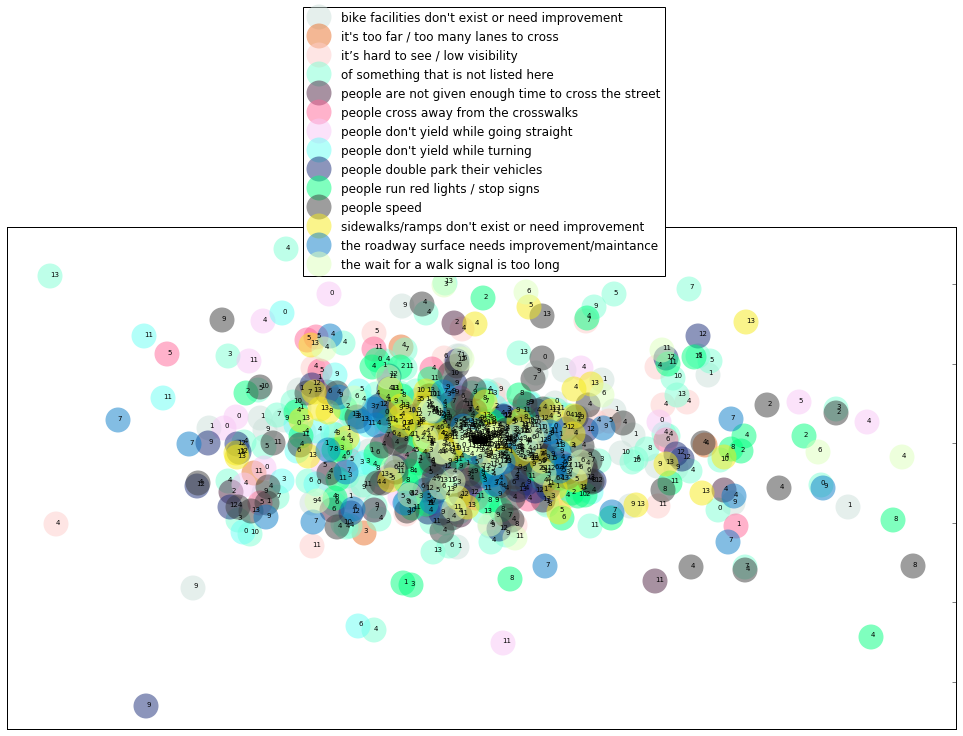

In [94]:
%matplotlib inline 


#create data frame that has the result of the MDS plus the cluster numbers and true label (REQUESTTYPE)
df_clustered = pd.DataFrame(dict(x=xs, y=ys, label=clusters, truelabel=y_val)) 

#group by true label
groups = df_clustered.groupby('truelabel')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I plot each point's color by its true label (REQUESTTYPE)
for truel, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=25, alpha=0.5,
            label=truel, color=cluster_colors[truel], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1, bbox_to_anchor=(0.7, 1.45))  #show legend with only 1 point

#add clustering label to each point 
for i in range(len(df_clustered)):
    ax.text(df_clustered.iloc[i]['x'], df_clustered.iloc[i]['y'], df_clustered.iloc[i]['label'], size=7)  

    
    
plt.show()

Can't tell too much from the 2-D plot, still looks like a blob

#### Well matched ones for K-means   

Cluster 2 matches **people speed**: speed; street; peopl; peopl speed; thi; thi street; car; speed thi; cut; car speed;

Cluster 1 matches **people double parked their vechicles**: doubl park; doubl; park; peopl doubl; peopl doubl park; lane; peopl; car; bike; car doubl park;  

Cluster 7 matches **people don't yield while turning**: don t; don; t; don t yield; t yield; yield; pedestrian; don t stop; t stop; car don t; 

Cluster 5 matches **the wait for a walk signal is too long**: signal; walk; walk signal; cross; pedestrian; long; time; wait; light; cross walk;

Cluster 8 could be matching **bike facilities don't exist or need improvement** : bike lane; bike; lane; need; park; car; park bike; park bike lane; road; protect;

# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


#### Thoughts: 
The fourth component of NMF contains features ['direction' 'use' 'south' 'fast' 'street way' 'way way' 'cut'
 'drive wrong way' 'drive wrong' 'children' 'parking' 'cross street'
 'speed' 'wrong way' 'narrow' 'wrong' 'drive' 'way street' 'way' 'street'], seems to me that it could be grouped as a new topic as **drive wrong way**
 
The key words for **surface improvement/matainance** could used LDA (w/o stemming) Component 5 has top 20 features as: 
['station' 'bumps' 'narrow' 'sidewalk' 'road surface' 'uneven' 'potholes'
 'road' 'forest hills' 'surface' 'forest' 'hills' 'bikes' 'people' 'area'
 'speed' 'sidewalks' 'bike lanes' 'bike' 'lanes']


#### (part a) 
Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.

result summary:  
(1) After examining keywords from topics modelling && clustering, we decide to combine "people don't yeild while turning" and "people don't yeild while going straight", as the latter is easily being misclassified as the former. 


(2) Given "people don't have enough time to cross" has confusing comment, we relabel some of them to "people don't yield while walking or driving" if contains key words "yield" and relabel some entries to "people speed" if contain key words "fast", and move entries to the other category if they don't contain key word "not enough time".

(3) We observe that keywords "wrong way" show up as a topic, which previously doesn't exist, so we create one if the comment matches the keywords. 

Eventually we have 15 classes, and they are:
  
['of something that is not listed here', 'people speed',
       'it’s hard to see / low visibility',
       'people run red lights / stop signs',
       'the wait for a walk signal is too long',
       "people don't yeild while driving or walking",
       "bike facilities don't exist or need improvement",
       "it's too far / too many lanes to cross",
       'people cross away from the crosswalks',
       'the roadway surface needs improvement/maintance',
       "sidewalks/ramps don't exist or need improvement",
       'people double park their vehicles', 'people on wrong way']  

#### Overall, we increase F1 macro from 0.572 to 0.598  

In [95]:
def replace_label(X, y, keys, newtopic, threshold):
    idxs = [i for i, line in enumerate(X) if is_match(keys, line, threshold)]
    print (len(idxs))
    y_ = np.array(y)
    y_[idxs] = newtopic
    return y_
    

In [96]:
def gen_discrete_key(key_list):
    r"""takes in a key words with potential repeated words
    Returns
    -------
    a list of unique key words
    """
    key_set = set([])
    for k in key_list:
        ks = k.split(" ")
        for kk in ks:
            key_set.add(kk)
    return list(key_set)

In [97]:
def count_total_match(keys, texts, threshold):
    r"""count in a list of text, return the total number of them that matches keywords
    """
    counter = 0
    for text in texts:
        text_list = text.split(" ")
        n_of_match = len([PorterStemmer().stem(i) for i in text_list if PorterStemmer().stem(i) in keys])
        if n_of_match > threshold:
            counter += 1
    return (counter)

In [98]:
def is_match(keys, text, threshold):
    r"""for a single line of text, determine if it matches the keywords
    """
    text_list = text.split(" ")
    n_of_match = len([PorterStemmer().stem(i) for i in text_list if PorterStemmer().stem(i) in keys])
    if n_of_match >= threshold:
        return True
    else:
        return False

In [99]:
def gen_logisticregression_f1(Xtrian, Xtest, ytrain, ytest):
    tfidf = TfidfVectorizer(tokenizer=stemTokenizer(), ngram_range=(1, 3), min_df=3, stop_words='english')
    Xtrain_tfidf = tfidf.fit_transform(Xtrian)
    lr_tfidf = LogisticRegressionCV(scoring="f1_macro").fit(Xtrain_tfidf, ytrain)
    Xtest_tfidf = tfidf.transform(Xtest)
    f1s = lr_tfidf.score(Xtest_tfidf, ytest)
    return f1s

#### I found "people don't yield while going straight" has low correctness based on the confusion matrix, 
and it has 0.22 fraction being mislabeled as "people don't yeild while turning". Also, given clustering/topic modelling produces a topic contains "don't yeild", then I am going to combine these two topics in to a more general one, called "people don't yield while walking or driving" 

In [100]:
topics_to_be_combined = ["people don't yield while turning", "people don't yield while going straight"]

In [101]:
new_topic = "people don't yeild while driving or walking"

In [102]:
"people don't yield while turning" in topics_to_be_combined

True

In [103]:
def replace_label_by_topic(topics_to_be_replaced, newtopic, ys):
    r"""replace topics if the current topic matches elements in topics_to_be_replaced
    Returns
    -------
    y_ : list
      a list of y label with replaced topics
    """
    idxs = [i for i,y in enumerate(ys) if y in topics_to_be_replaced]
    print (len(idxs))
    y_ = np.array(ys)
    y_[idxs] = newtopic
    return y_

In [104]:
y_train_sub1 = replace_label_by_topic(topics_to_be_combined, new_topic, y_train_sub)
y_val1 = replace_label_by_topic(topics_to_be_combined, new_topic, y_val)

531
177


In [105]:
gen_logisticregression_f1(text_train_sub, text_val, y_train_sub1, y_val1)

0.57894736842105265

the previous best f1-macro score is 0.572, now it is 0.579, increase by 0.7%

#### We also observe that "people speed", "people are not given enough time to cross the street", "people don't yeild while turning" are three confusing classes for the model. 
Thus we are going to relabel "people speed", "people are not given enough time to cross the street" to "people don't yeild while turning" if they contain keywords "dont yield".   
Relabel "people are not given enough time to cross the street" into "people speed" if contain keywords "drive fast", for those that doesn't contain "not enough time", move them to "others" (After manual examination, we find out that "people are not given enough time to cross the street" is a small class, and lots of comments actually belong to other category; hence the relabel.)

In [106]:
# relabel "people speed", "people are not given enough time to cross the street" 
# to "people don't yeild while driving or walking" if they contain keywords "dont yield"

In [107]:
def replace_label_by_topic_with_matchingkey(topics_to_be_replaced, newtopic, ys, keys, texts, threshold):
    r"""replace topics if the current topic matches elements in topics_to_be_replaced
    Returns
    -------
    y_ : list
      a list of y label with replaced topics
    """
    idxs = [i for i,y in enumerate(ys) if y in topics_to_be_replaced and is_match(keys, list(texts)[i], threshold)]
    print (len(idxs))
    print(idxs)
    y_ = np.array(ys)
    y_[idxs] = newtopic
    return y_

In [108]:
list(text_train_sub)[2]

'A dog was killed by traffic. Very concerned for kids'

In [109]:
topics_to_be_relabeled = ["people are not given enough time to cross the street" ]
matching_keywords = ["yield"]
matching_keywords

['yield']

In [110]:
TESTY=["NO", "people are not given enough time to cross the street"]
TEST = ["yeild", "yield"]

In [111]:
 list(TEST)[1]

'yield'

In [112]:
is_match(matching_keywords, list(TEST)[1], 1)

True

In [113]:
[i for i,y in enumerate(TESTY) if (y in topics_to_be_relabeled and is_match(matching_keywords, list(TEST)[i], 1) )]

[1]

In [114]:
topics_to_be_relabeled = ["people speed","people are not given enough time to cross the street" ]
matching_keywords = ["yield"]

In [115]:
y_train_sub2 = replace_label_by_topic_with_matchingkey(topics_to_be_relabeled, "people don't yeild while driving or walking", y_train_sub1, matching_keywords, text_train_sub, 1)

30
[24, 90, 204, 274, 396, 583, 641, 738, 746, 816, 836, 985, 1072, 1131, 1288, 1649, 1841, 1942, 2195, 2344, 2954, 3091, 3812, 4079, 4137, 4389, 4562, 4605, 4613, 4794]


In [116]:
y_val2 = replace_label_by_topic_with_matchingkey(topics_to_be_relabeled, "people don't yeild while driving or walking", y_val1, matching_keywords, text_val, 1)

7
[302, 312, 806, 1246, 1289, 1538, 1575]


In [117]:
list(text_train_sub)[3812]

"Speeding drivers don't yield to pedestrians!  Pedestrians fearfully must yield to drivers.  I have never seen police enforce against a driver proactively in years!"

In [118]:
len([y for y in y_train_sub2 if y == "people are not given enough time to cross the street" ])

93

In [119]:
# relabel "people are not given enough time to cross the street" to "people speed" if contain keywords like "drive" " fast"

In [120]:
topics_to_be_relabeled = ["people are not given enough time to cross the street" ]
matching_keywords = ["fast"]
y_train_sub3 = replace_label_by_topic_with_matchingkey(topics_to_be_relabeled, "people speed", y_train_sub2, matching_keywords, text_train_sub, 1)

3
[1586, 3480, 3508]


In [121]:
y_val3 = replace_label_by_topic_with_matchingkey(topics_to_be_relabeled, "people speed", y_val2, matching_keywords, text_val, 1)

1
[621]


In [122]:
# for those "people are not given enough time to cross the street" if NOT contain keywords "enough" "time", move them to others category
topics_to_be_relabeled = ["people are not given enough time to cross the street" ]
matching_keywords = ["time", "enough", "not", "no"]


In [123]:
def replace_label_by_topic_with_notmatchingkey(topics_to_be_replaced, newtopic, ys, keys, texts, threshold):
    r"""replace topics if the current topic matches elements in topics_to_be_replaced
    Returns
    -------
    y_ : list
      a list of y label with replaced topics
    """
    idxs = [i for i,y in enumerate(ys) if y in topics_to_be_replaced and not is_match(keys, list(texts)[i], threshold)]
    print (len(idxs))
    print(idxs)
    y_ = np.array(ys)
    y_[idxs] = newtopic
    return y_

In [124]:
y_train_sub4 = replace_label_by_topic_with_notmatchingkey(topics_to_be_relabeled, "of something that is not listed here", y_train_sub3, matching_keywords, text_train_sub, 2)

68
[34, 156, 384, 435, 448, 540, 561, 616, 781, 809, 847, 935, 999, 1338, 1347, 1466, 1785, 1836, 1901, 2033, 2039, 2176, 2198, 2209, 2359, 2472, 2493, 2636, 2693, 2814, 2852, 2855, 2906, 3029, 3031, 3046, 3081, 3186, 3192, 3233, 3291, 3323, 3334, 3359, 3370, 3437, 3468, 3535, 3574, 3626, 3660, 3763, 3828, 3875, 3960, 3987, 4064, 4107, 4171, 4324, 4424, 4512, 4576, 4644, 4690, 4730, 4736, 4834]


In [125]:
y_val4 = replace_label_by_topic_with_notmatchingkey(topics_to_be_relabeled, "of something that is not listed here", y_val3, matching_keywords, text_val, 2)

18
[38, 91, 164, 458, 469, 629, 697, 701, 742, 1031, 1052, 1082, 1092, 1295, 1453, 1523, 1531, 1572]


In [126]:
gen_logisticregression_f1(text_train_sub, text_val, y_train_sub4, y_val4)

0.5851393188854489

increase F1-macro by 0.6% 

since "drive wrong way" occur as a topic, I will create this new class

In [127]:
def replace_label(X, y, keys, newtopic, threshold):
    idxs = [i for i, line in enumerate(X) if is_match(keys, line, threshold)]
    print (len(idxs))
    y_ = np.array(y)
    y_[idxs] = newtopic
    return y_
    

In [128]:
matching_keywords = ["wrong", "way"]
y_train_sub5 = replace_label( text_train_sub, y_train_sub4, matching_keywords, "people on wrong way", 2)

73


In [129]:
y_val5 = replace_label( text_val, y_val4, matching_keywords, "people on wrong way", 2)

27


In [130]:
gen_logisticregression_f1(text_train_sub, text_val, y_train_sub5, y_val5)

0.58328173374613002

since after relabeling the class distribution changed, I am going to perform train-test-split again

In [131]:
df1 = pd.DataFrame({"COMMENT": list(text_train_sub), "REQUESTTYPE":list(y_train_sub5)})

In [132]:
df1.head()

,COMMENT,REQUESTTYPE
0,"At evening rush hour, car traffic is often bac...",of something that is not listed here
1,Linden Street is a direct artery to the highwa...,people speed
2,A dog was killed by traffic. Very concerned fo...,people speed
3,Cars drive the wrong direction down this road.,of something that is not listed here
4,it is hard to see when exiting dresden to spri...,it’s hard to see / low visibility


In [133]:
df2 = pd.DataFrame({"COMMENT": list(text_val), "REQUESTTYPE":list(y_val5)})

In [134]:
df2.head()

,COMMENT,REQUESTTYPE
0,It would help to have a left turn arrow for dr...,it’s hard to see / low visibility
1,Drivers turning right onto Washington St do no...,people run red lights / stop signs
2,The discontinuity in Knoll street makes it dif...,it’s hard to see / low visibility
3,"To access the commuter rail station, people wi...",people cross away from the crosswalks
4,"bad patches cause dangerous surface, right whe...",the roadway surface needs improvement/maintance


In [135]:
df3 = pd.concat([df1, df2])

In [136]:
df3.head()

,COMMENT,REQUESTTYPE
0,"At evening rush hour, car traffic is often bac...",of something that is not listed here
1,Linden Street is a direct artery to the highwa...,people speed
2,A dog was killed by traffic. Very concerned fo...,people speed
3,Cars drive the wrong direction down this road.,of something that is not listed here
4,it is hard to see when exiting dresden to spri...,it’s hard to see / low visibility


In [137]:
df3.shape

(6460, 2)

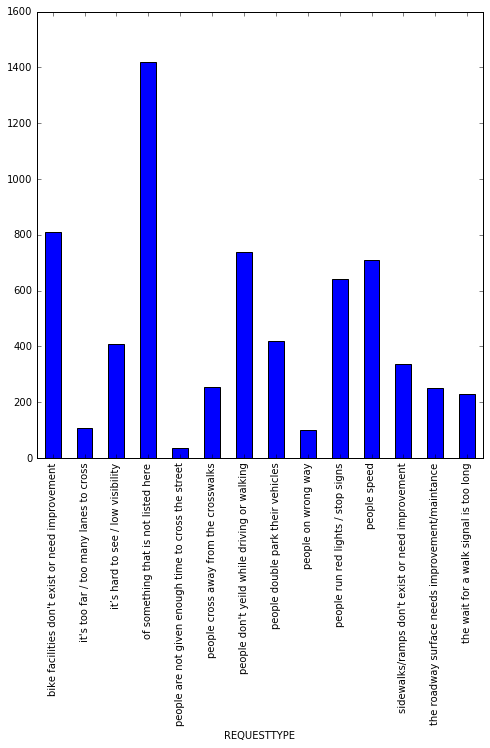

In [138]:
# visualize the class distribution 
%matplotlib inline
df3.groupby('REQUESTTYPE').count()['COMMENT'].plot(kind="bar", figsize=(8,8))

In [139]:
df3["REQUESTTYPE"].unique()

array(['of something that is not listed here', 'people speed',
       'it’s hard to see / low visibility',
       'people run red lights / stop signs',
       'the wait for a walk signal is too long',
       "people don't yeild while driving or walking",
       "bike facilities don't exist or need improvement",
       "it's too far / too many lanes to cross",
       'people cross away from the crosswalks',
       'people are not given enough time to cross the street',
       'the roadway surface needs improvement/maintance',
       "sidewalks/ramps don't exist or need improvement",
       'people double park their vehicles', 'people on wrong way'], dtype=object)

In [140]:
text_train_sub0, text_val0, y_train_sub0, y_val0 = train_test_split(df3["COMMENT"], df3["REQUESTTYPE"], stratify=df3["REQUESTTYPE"], random_state=0)

In [141]:
gen_logisticregression_f1(text_train_sub0, text_val0, y_train_sub0, y_val0)

0.59814241486068109

In [142]:
assert gen_logisticregression_f1(text_train_sub0, text_val0, y_train_sub0, y_val0) > 0.57

#### after regrouping, we achieve f1 score as 0.598

#### (part b) break "of something that is not listed here" into subtopics
result summary:  

We break "of something that is not listed here" in to "not turning correctly at left or right lane", "people on wrong way", "no stop sign" and the rest   
, achieves 0.917 f1-macro score

In [143]:
idxs = [i for i, j in enumerate(y_val) if j == 'of something that is not listed here']

In [144]:
len([list(y_val)[i] for i in idxs]) # number of "other type" instance in test set

350

In [145]:
def get_others(X, y ):
    r""" find comments with "of something that is not listed here" as its class type
    Returns
    -------
    texts : list 
       a list of text 
    oy : list
       a list of "of something that is not listed here"
    """
    idxs = [i for i, j in enumerate(y) if j == 'of something that is not listed here']
    texts = [list(X)[i] for i in idxs]
    oy = [list(y)[i] for i in idxs]
    return texts, oy

In [146]:
others_train, y_others_train = get_others(text_train_sub, y_train_sub)
others_test, y_others_test = get_others(text_val, y_val)

In [147]:
len(others_test)

350

In [148]:
others_test[:2]

["People drive in the oncoming lane because they think it's a one way street heading towards Market.  There is no yellow line to indicate otherwise.  I see this at least once a week.",
 'Narrow right turn when turning onto Savin Hill Ave from Pleasant street. Allowing cars to park all the way to the corners makes it difficult to turn.']

In [149]:
def NMF_scale(text_train, text_test):
    X_train = tfidf.fit_transform(text_train)
    X_test = tfidf.transform(text_test)
    
    scaler = MaxAbsScaler()
    X_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    nmf_scale = NMF(n_components=4, verbose=14, tol=0.01)
    nmf_scale.fit(X_scaled)
    X_nmf_scale = nmf_scale.transform(X_scaled)
    # plot topics
    large_comp_inds = np.argsort(X_nmf_scale.mean(axis=0))[::-1]
    feature_names = np.array(tfidf.get_feature_names())
    print_topics(large_comp_inds, feature_names, nmf_scale.components_)
    

In [150]:
NMF_scale(others_train, others_test)

violation: 1.0
violation: 0.6234701528788336
violation: 0.3403289180406451
violation: 0.21303634223043935
violation: 0.14866153374042762
violation: 0.10835633710338524
violation: 0.082353376045352
violation: 0.0643187605998528
violation: 0.05031671779105918
violation: 0.03976252975639088
violation: 0.031986375655636216
violation: 0.026240770305217414
violation: 0.022181462106517454
violation: 0.01932323959628322
violation: 0.017384175148836334
violation: 0.015997446793023076
violation: 0.015096160876657258
violation: 0.014485292100854186
violation: 0.014090695758361893
violation: 0.013873944094149581
violation: 0.013741739645746223
violation: 0.013666837448879204
violation: 0.013623794315723508
violation: 0.013602847479934429
violation: 0.013573236388696378
violation: 0.013561487278027334
violation: 0.013512676684006462
violation: 0.013508348851186725
violation: 0.013515534568974558
violation: 0.013532891168466957
violation: 0.01356641513219338
violation: 0.013610572648405348
violation

In [151]:
def get_LDA(text_train):
    X_train = tfidf.fit_transform(text_train)
    lda = LatentDirichletAllocation(n_topics=4, learning_method="batch")
    X_lda = lda.fit_transform(X_train)
    print_topics(np.argsort(X_lda.sum(axis=0))[::-1], feature_names, lda.components_, topics_per_chunk=4)

In [152]:
get_LDA(others_train)

topic 1                 topic 2                 topic 3                 topic 0                 
--------                --------                --------                --------                
actual                  bike becaus             bike lane peopl         charl                   
board                   case                    car traffic cross       car pleas add           
bike becaus             bike lane end           area car park           board                   
car pleas add           alford st               centr                   children car            
alford st               buss                    car street              children live play      
aggress driver          better mark             case                    bremen                  
car like                bike lane make          car turn right          car like                
actual need             aren mark               bremen                  charlesg                
car crosswalk           box bl

In [153]:
def get_Kmeans(text_train, k=4):
    X_train = tfidf.fit_transform(text_train)
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X_train_tfidf)
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    for i in range(k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :20]: # take ith row of the matrix and print first 10 of the elements 
            print(' %s' % terms[ind], end=';')
        print()

In [154]:
get_Kmeans(others_train, k=4)

Cluster 0: street; park; peopl; car; speed; sidewalk; traffic; crosswalk; way; st; veri; road; turn; need; cross; intersect; danger; bike; pedestrian; make;
Cluster 1: lane; bike; bike lane; park; car; turn; left; right; need; peopl; facil; bike facil; park bike; traffic; park bike lane; road; straight; danger; st; ave;
Cluster 2: stop; stop sign; sign; crosswalk; car; driver; bus; peopl; cross; pedestrian; bus stop; stop stop; street; stop pedestrian; intersect; way; st; stop stop sign; speed; run stop;
Cluster 3: light; walk; cross; pedestrian; red; turn; signal; red light; run; car; walk signal; time; driver; yield; traffic; green; peopl; intersect; crosswalk; run red;


#### Thoughts: potential topics:
"lacking stop sign or stop sign not working well" 
"drive wrong way" 

#### Make "people drive wrong way" a new subtopic

In [155]:
others_train, y_others_train = get_others(text_train_sub, y_train_sub)
others_test, y_others_test = get_others(text_val, y_val)

In [156]:
text_train[:2]

0    the roadway is super wide here with no lane ma...
1    As someone who walks from SE of the intersecti...
Name: COMMENTS, dtype: object

In [157]:
keys = ["drive", "wrong", "way", "buse"]

In [158]:
def gen_discrete_key(key_list):
    r"""takes in a key words with potential repeated words
    Returns
    -------
    a list of unique key words
    """
    key_set = set([])
    for k in key_list:
        ks = k.split(" ")
        for kk in ks:
            key_set.add(kk)
    return list(key_set)

In [159]:
gen_discrete_key(["drive wrong way", "way", "wrong", "driver"])

['wrong', 'driver', 'drive', 'way']

In [160]:
# example 
counter = 0
texts = ["I drive wrong way to school", "i didn't like the buses"]
for text in texts:
    text_list = text.split(" ")
    n_of_match = len([PorterStemmer().stem(i) for i in text_list if PorterStemmer().stem(i) in keys])
    if n_of_match > 2:
        counter += 1
print (counter)

1


In [161]:
def count_total_match(keys, texts, threshold):
    r"""count in a list of text, return the total number of them that matches keywords
    """
    counter = 0
    for text in texts:
        text_list = text.split(" ")
        n_of_match = len([PorterStemmer().stem(i) for i in text_list if PorterStemmer().stem(i) in keys])
        if n_of_match >= threshold:
            counter += 1
    return (counter)

In [162]:
keys = ["drive", "wrong", "way"]
count_total_match(keys, others_train,   2)

66

In [163]:
def is_match(keys, text, threshold):
    r"""for a single line of text, determine if it matches the keywords
    """
    counter = 0
    text_list = text.split(" ")
    n_of_match = len([PorterStemmer().stem(i) for i in text_list if PorterStemmer().stem(i) in keys])
    if n_of_match >= threshold:
        return True
    else:
        return False

In [164]:
p = np.array([12,11,10])
p[[1,2]] = 0
p

array([12,  0,  0])

In [165]:
def gen_matching_index(X, y):
    idxs = [i for i, line in enumerate(X) if is_match(keys, line, 2)]
    print (idxs)
    return idxs

In [166]:
len(gen_matching_index(others_train, y_train_sub))

[0, 1, 27, 48, 59, 103, 115, 118, 138, 149, 160, 163, 168, 182, 187, 227, 253, 261, 268, 276, 306, 307, 315, 403, 406, 410, 427, 432, 446, 456, 469, 482, 523, 526, 534, 542, 566, 570, 591, 604, 614, 631, 642, 670, 739, 750, 758, 762, 769, 807, 820, 838, 844, 862, 876, 878, 885, 894, 915, 936, 943, 973, 976, 1010, 1038, 1046]


66

In [167]:
others_train[27]

"public service crews, including DPW, drive the wrong way on Royal St when providing service, including plowing and trash pick up.  They don't see bikes heading down the street with flow of traffic."

In [168]:
def replace_label(X, y, keys, newtopic, threshold):
    idxs = [i for i, line in enumerate(X) if is_match(keys, line, threshold)]
    print (len(idxs))
    y_ = np.array(y)
    y_[idxs] = newtopic
    return y_
    

In [169]:
re_y_others_train = replace_label(others_train, y_others_train, keys, "people on wrong way", 2)
re_y_others_test = replace_label(others_test, y_others_test, keys, "people on wrong way", 2)

66
24


In [170]:
len([y for y in re_y_others_train if y == "people on wrong way"]) == 66

True

In [171]:
# try classify on this binary class "people on wrong way" vs. rest
def gen_logisticregression_f1(Xtrian, Xtest, ytrain, ytest):
    tfidf = TfidfVectorizer(tokenizer=stemTokenizer(), ngram_range=(1, 3), min_df=3, stop_words='english')
    Xtrain_tfidf = tfidf.fit_transform(Xtrian)
    lr_tfidf = LogisticRegressionCV(scoring="f1_macro").fit(Xtrain_tfidf, ytrain)
    Xtest_tfidf = tfidf.transform(Xtest)
    f1s = lr_tfidf.score(Xtest_tfidf, ytest)
    return f1s

In [172]:
gen_logisticregression_f1(others_train, others_test, re_y_others_train, re_y_others_test)

0.96571428571428575

"people on wrong way" achieves 0.98 f1 score, it could be a subclass

#### add "no stop sign" as a new subtopic of "others"

In [173]:
keys1 = ["no", "stop", "sign", "missing"]
count_total_match(keys1, others_train,   3)

23

In [174]:
re_y_others_train1 = replace_label(others_train, re_y_others_train, keys1, "no stop sign", 3)
re_y_others_test1 = replace_label(others_test, re_y_others_test, keys1, "no stop sign",3)

23
7


In [175]:
len([y for y in re_y_others_train1 if y == "no stop sign"]) == 23

True

In [176]:
gen_logisticregression_f1(others_train, others_test, re_y_others_train1, re_y_others_test1)

0.95714285714285718

#### add "not turning at correctly at left/right lane " as a new subtopic of "others"

In [177]:
keys2 = ["left", "right", "lane", "turn"]
count_total_match(keys2, others_train,   2)

224

In [178]:
re_y_others_train2 = replace_label(others_train, re_y_others_train1, keys2, "not turning correctly at left or right lane", 2)

224


In [179]:
re_y_others_train2[:5]

array(['people on wrong way', 'people on wrong way',
       'of something that is not listed here',
       'of something that is not listed here',
       'not turning correctly at left or rig'], 
      dtype='<U36')

In [180]:
len([y for y in re_y_others_train2 if y == "not turning correctly at left or rig"]) == 224

True

In [181]:
re_y_others_test2 = replace_label(others_test, re_y_others_test1, keys2, "not turning correctly at left or right lane",2)

69


In [182]:
gen_logisticregression_f1(others_train, others_test, re_y_others_train2, re_y_others_test2)

0.91714285714285715

In [183]:
assert gen_logisticregression_f1(others_train, others_test, re_y_others_train2, re_y_others_test2) > 0.53

#### We break "of something that is not listed here" in to "not turning correctly at left or right lane", "people on wrong way", "no stop sign" and achieves 0.917 f1-macro score

# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6. 

### used word2vec
#### Result summary:  

achieves 0.561 score for task3, which is around 1% lower than the tfidf (1,3) gram model, since for this pre-trained word2vec, we are only allowed to use single words, the previous model holds advantages in terms of multigrams. 
 
0.572 for task6 part a (relabel performed on the entire dataset),  which is 2% lower than the previous model. 

0.939 for task6 part b (relabel "others" category), which is 2.2% higher than 0.917 of the previous task 6 part b score

In [703]:
# Add your code for extra credit here. You may use multiple cells.
print(text_train_sub.shape, text_val.shape, y_train_sub.shape, y_val.shape)

(4845,) (1615,) (4845,) (1615,)


### Redo Task 3 classification using Doc2Vec

In [100]:
from gensim import models
#w = models.KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

In [101]:

def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])

In [107]:
text_train_sub.shape

(4845,)

In [102]:
import gensim
train_corpus = list(read_corpus(text_train_sub))
test_corpus = list(read_corpus(text_val, tokens_only=True))

In [103]:
train_corpus[0]

TaggedDocument(words=['at', 'evening', 'rush', 'hour', 'car', 'traffic', 'is', 'often', 'backed', 'up', 'on', 'west', 'bound', 'side', 'drivers', 'too', 'impatient', 'to', 'wait', 'often', 'drive', 'on', 'the', 'wrong', 'side', 'of', 'the', 'road', 'to', 'pass', 'the', 'line', 'of', 'cars'], tags=[0])

In [104]:
text_train_sub[3595]

'At evening rush hour, car traffic is often backed-up on west-bound side. Drivers too impatient to wait often drive on the wrong side of the road to pass the line of cars.'

In [130]:

model = gensim.models.doc2vec.Doc2Vec(size=400, min_count=4, iter=60)
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)

CPU times: user 31.6 s, sys: 4.26 s, total: 35.9 s
Wall time: 17.6 s


5015914

In [131]:
model.wv.vocab['bike'].count

1007

In [141]:
import pickle
with open("doc2vec.pickle", "wb") as f:
    pickle.dump(model, f, -1)

In [133]:
vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]

In [134]:
X_train = np.vstack(vectors)

In [135]:
X_train.shape

(4845, 400)

In [136]:
test_vectors = [model.infer_vector(test_corpus[doc_id])
                for doc_id in range(len(test_corpus))]

In [137]:
X_val = np.vstack(test_vectors)

In [144]:
from sklearn.linear_model import LogisticRegression
%time lr_d2v = LogisticRegressionCV(scoring='f1_macro').fit(X_train, y_train_sub)

CPU times: user 1min 36s, sys: 3.31 s, total: 1min 39s
Wall time: 1min 6s


In [145]:
# on test set
lr_d2v.score(X_val, y_val)

0.32136222910216716

In [146]:
# on train set could be overfitting
lr_d2v.score(X_train, y_train_sub)

0.41816305469556242

#### doc2vec is below 0.5... could be because the corpus has too little documents to work, might it better to go for word2vec instead

### Redo TASK3 with word2vec 
#### achieves 0.56 f1-macro score, only 1% lower than logistic regression with tfidf (1,3) gram. 

comment out as this GoogleNews-vectors-negative300.bin file is 1.6G large, and can't be uploaded to git repository

In [1026]:
# from gensim import models
# %time w = models.KeyedVectors.load_word2vec_format('/Volumes/STARTRACK/GoogleNews-vectors-negative300.bin', binary=True)

CPU times: user 59.7 s, sys: 16.4 s, total: 1min 16s
Wall time: 1min 30s


In [1235]:
# w['buse'].shape

(300,)

In [1028]:
# w.syn0.shape

(3000000, 300)

In [1030]:
# w.index2word [:3]

['</s>', 'in', 'for']

In [1031]:
# w.index2word [33:37]

['but', '$', 'had', 'year']

In [1392]:
# vect_w2v = CountVectorizer( vocabulary=w.index2word) 

In [1393]:
# #vect_w2v = TfidfVectorizer(vocabulary=w.index2word, min_df=3, stop_words='english')

In [1394]:
# text_train_sub, text_val, y_train_sub, y_val = train_test_split(text_train, y_train, stratify=y_train, random_state=0)

In [1395]:
# text_train_sub.shape

(4845,)

In [1396]:
# vect_w2v.fit(text_train_sub)
# docs = vect_w2v.inverse_transform(vect_w2v.transform(text_train_sub))

In [1397]:
# docs[1]

array(['is', 'the', 'not', 'as', 'this', 'do', 'area', 'street', 'direct',
       'residential', 'recognize', 'highway', 'motorists', 'artery',
       'linden'], 
      dtype='<U98')

In [1398]:
# docs[1].shape

(15,)

In [1399]:
# list(text_train_sub)[1]

'Linden Street is a direct artery to the highway. Motorists do not recognize this as a residential area.'

In [1400]:
# w[docs[1]].shape

(15, 300)

In [1401]:
# np.mean(w[docs[1]], axis=0).shape #(300,) get mean over each columns operate over rows

(300,)

In [1402]:
# len(docs)

4845

In [1403]:
# len(docs[1808])

0

In [1404]:
# list(text_train_sub)[1808]

'G'

In [1405]:
# del docs[1808] # remove empty doc entry

In [1406]:
# len(docs)

4844

In [1407]:
# list(y_train_sub)[1808]

"it's too far / too many lanes to cross"

In [1408]:
# df[df['COMMENTS'] == 'G']

,﻿X,Y,OBJECTID,GLOBALID,REQUESTID,REQUESTTYPE,REQUESTDATE,STATUS,STREETSEGID,COMMENTS,USERTYPE
202,-71.063376,42.36404,18962,NaN,NaN,people have to cross too many lanes / too far,2016-01-24T03:17:06.000Z,Unassigned,0,G,bikes
921,-71.063376,42.36404,19770,NaN,19770.0,people have to cross too many lanes / too far,2016-01-24T03:17:06.000Z,Unassigned,0,G,bikes


In [1409]:
# y_train_sub[921]

"it's too far / too many lanes to cross"

In [1410]:
# del y_train_sub[921]

In [1411]:
# y_train_sub.shape

(4844,)

In [1412]:
def get_vecs(documents):
    r"""
    Returns
    -------
    stk : np.ndarray
      a mx300 matrix, where m === number of document
    """
    stk = [0]*300
    for doc in documents:
        new = np.array(np.mean(w[doc], axis=0))
        stk = np.vstack((np.array(stk), new))
    return stk[1:] #remove the very first all 0s line

In [1413]:
# X_train = get_vecs(docs)

In [1414]:
# X_train = np.vstack([np.mean(w[doc], axis=0) for doc in docs])

In [1415]:
# X_train.shape

(4844, 300)

In [1416]:
# docs_val = vect_w2v.inverse_transform(vect_w2v.transform(text_val))

In [1417]:
# for i, val in enumerate(docs_val):
#     if len(val) == 0:
#         print (i)

In [1418]:
# X_val = np.vstack([np.mean(w[doc], axis=0) for doc in docs_val])

In [1419]:
# %time lr_w2v = LogisticRegressionCV(scoring='f1_macro').fit(X_train, y_train_sub)

CPU times: user 1min 8s, sys: 2.45 s, total: 1min 10s
Wall time: 51 s


In [1420]:
# lr_w2v.score(X_val, y_val)

0.56160990712074299

In [1421]:
# lr_w2v.score(X_train, y_train_sub)

0.70189925681255161

#### redo TASK 6, part a 

In [1210]:
# docs0 = vect_w2v.inverse_transform(vect_w2v.transform(text_train_sub0))

In [1211]:
# docs_val0 = vect_w2v.inverse_transform(vect_w2v.transform(text_val0))

In [1212]:
# X_train0 = np.vstack([np.mean(w[doc], axis=0) for doc in docs0])

In [1213]:
# find me empty doc index in docs
# for i, doc in enumerate(docs_val0):
#     if len(doc) == 0:
#         print (i)

832


In [1215]:
# df3[df3['COMMENT'] == 'G']

,COMMENT,REQUESTTYPE
1808,G,it's too far / too many lanes to cross


In [1216]:
# y_val0[1808]

"it's too far / too many lanes to cross"

In [1217]:
# del docs_val0[832] # by index starts from 0

In [1218]:
# del y_val0[1808] # by encoded index from original dataframe

In [1219]:
# X_val0 = np.vstack([np.mean(w[doc], axis=0) for doc in docs_val0])

In [1220]:
# %time lr_w2v_t6a = LogisticRegressionCV(scoring='f1_macro').fit(X_train0, y_train_sub0)

CPU times: user 57.7 s, sys: 2.15 s, total: 59.9 s
Wall time: 43.4 s


In [1221]:
# lr_w2v_t6a.score(X_train0, y_train_sub0)

0.71599587203302373

In [1222]:
# lr_w2v_t6a.score(X_val0, y_val0)

0.57249070631970256

redo TASK 6 part b

In [1223]:
# docs_others = vect_w2v.inverse_transform(vect_w2v.transform(others_train))

In [1225]:
# docs_val_others = vect_w2v.inverse_transform(vect_w2v.transform(others_test))

In [1226]:
# X_train_others = np.vstack([np.mean(w[doc], axis=0) for doc in docs_others])

In [1227]:
# X_val_others = np.vstack([np.mean(w[doc], axis=0) for doc in docs_val_others])

In [1228]:
# %time lr_w2v_t6b = LogisticRegressionCV(scoring='f1_macro').fit(X_train_others, re_y_others_train)

CPU times: user 892 ms, sys: 83.9 ms, total: 976 ms
Wall time: 807 ms


In [1229]:
# lr_w2v_t6b.score(X_train_others, re_y_others_train)

0.99142857142857144

In [1231]:
# lr_w2v_t6b.score(X_val_others, re_y_others_test)

0.93999999999999995

#### w2v achieves 2% higher score on classifying the "other" category